# COVID-19 Philippine Data Analysis

This notebook aims to explore the features within the available data provided by the Philippine Department of Health (DOH) regarding the Coronavirus in the Philippines. The analysis contained herein shall aim to provide visualizations and basic exploratory data analysis using the different modules and libraries discussed in the course Data Preparation and Integration - DATAPRE.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely.geometry import Point

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Reading the Files

The following datasets were retrieved from the DOH Data drop which is readily available on the DOH's COVID-19 Dashboard. The files within the data drop are regularly updated, such that the data within this notebook was was last updated during June 27, 2022.

DOH Data Drop: https://drive.google.com/drive/folders/1TWm6j4jjgFpCoo2RQMgVotslcpVqgI06

In [2]:
data_1 = pd.read_csv('data/Case Information_batch_0.csv')
data_2 = pd.read_csv('data/Case Information_batch_1.csv')
data_3 = pd.read_csv('data/Case Information_batch_2.csv')
data_4 = pd.read_csv('data/Case Information_batch_3.csv')

print('Data successfully loaded')

c:\users\adria\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Data successfully loaded


In [3]:
print('Data 1 shape:', data_1.shape)
print('Data 2 shape:', data_2.shape)
print('Data 3 shape:', data_3.shape)
print('Data 4 shape:', data_4.shape)

Data 1 shape: (1000000, 22)
Data 2 shape: (1000000, 22)
Data 3 shape: (1000000, 22)
Data 4 shape: (695652, 22)


Upon inspection, it can be identified that all of the datasets have the same columns. The datasets can then be combined using `concat` to form a single `DataFrame`, which contains all of the recorded cases.

In [4]:
data_1.columns

Index(['CaseCode', 'Age', 'AgeGroup', 'Sex', 'DateSpecimen',
       'DateResultRelease', 'DateRepConf', 'DateDied', 'DateRecover',
       'RemovalType', 'Admitted', 'RegionRes', 'ProvRes', 'CityMunRes',
       'CityMuniPSGC', 'BarangayRes', 'BarangayPSGC', 'HealthStatus',
       'Quarantined', 'DateOnset', 'Pregnanttab', 'ValidationStatus'],
      dtype='object')

In [5]:
case_data = pd.concat([data_1, data_2, data_3, data_4])
case_data.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,ProvRes,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus
0,C404174,38.0,35 to 39,FEMALE,NaN,2020-01-30,2020-01-30,NaN,NaN,RECOVERED,...,NEGROS ORIENTAL,DUMAGUETE CITY (CAPITAL),PH074610000,NaN,NaN,RECOVERED,NO,2020-01-21,NO,"Health Status is ""Recovered"", but no Date Reco..."
1,C462688,44.0,40 to 44,MALE,NaN,2020-01-30,2020-02-03,2020-02-01,NaN,DIED,...,NEGROS ORIENTAL,DUMAGUETE CITY (CAPITAL),PH074610000,NaN,NaN,DIED,NO,2020-01-18,NaN,NaN
2,C387710,60.0,60 to 64,FEMALE,2020-01-23,2020-01-30,2020-02-05,NaN,2020-01-31,RECOVERED,...,BOHOL,PANGLAO,PH071233000,NaN,NaN,RECOVERED,NO,2020-01-21,NO,Age or Birthdate is Invalid\nCase has Admittin...
3,C498051,63.0,60 to 64,MALE,2020-03-05,NaN,2020-03-06,2020-03-11,NaN,DIED,...,RIZAL,CAINTA,PH045805000,NaN,NaN,DIED,NO,NaN,NaN,"Case has Lab Result, but Result Date is blank\..."
4,C377460,49.0,45 to 49,MALE,NaN,NaN,2020-03-06,NaN,NaN,RECOVERED,...,BATANGAS,SANTO TOMAS,PH041028000,NaN,NaN,RECOVERED,NO,NaN,NaN,"Health Status is ""Recovered"", but no Date Reco..."


## Data Dictionary

As taken from the DataDrop Field Metadata, the following features can be described as: 

| Variable          | Definition                                |
| ---------         | ----------------------------------------  |
| Casecode          | Random code assigned for labelling cases  |
| Age               | Age                                       |
| AgeGroup          | Five-year age group                       |
| Sex               | Sex                                       |
| DateSpecimen      | Date when specimen was collected          |
| DateResultRelease | Date of release result                    |
| DateRepConf       | Date publicly announced as confirmed case |
| DateDied          | Date died                                 |
| DateRecover       | Date Recovered                            |
| RemovalType       | Type of removal (recovery or death)       |
| Admitted          | Binary variable indicating that the patient has been taken to the hospital |
| RegionRes         | Region of residence |
| ProvRes           | Province of residence |
| CityMunRes        | City of residence |
| CityMuniPSGC      | Philippine Standard Geographic Code of Municipality or City of residence |
| BarangayRes       | Barangay of residence |
| Barangay PSGC     | Philippine Standard Geographic Code of Municipality or City of residence |
| HealthStatus      | Known current health status of patient (asymptomatic, mild, severe, critical, died, recovered) |
| Quarantined       | Identifies if the patient has ever been home quarantined |
| DateOnset         | Date of onset symptoms |
| Pregnanttab       | If the patient was pregnant at any point during the COVID-19 condition |

Basic information can be drawn from the dataset using `describe` to identify descriptive statistics from numeric features and `dtypes` to identifye the types of data available per feature.

In [6]:
case_data.describe()

,Age
count,3.692746e+06
mean,3.781379e+01
std,1.795060e+01
min,-1.000000e+00
25%,2.500000e+01
50%,3.500000e+01
75%,5.000000e+01
max,1.070000e+02


In [7]:
case_data.dtypes

CaseCode              object
Age                  float64
AgeGroup              object
Sex                   object
DateSpecimen          object
DateResultRelease     object
DateRepConf           object
DateDied              object
DateRecover           object
RemovalType           object
Admitted              object
RegionRes             object
ProvRes               object
CityMunRes            object
CityMuniPSGC          object
BarangayRes           object
BarangayPSGC          object
HealthStatus          object
Quarantined           object
DateOnset             object
Pregnanttab           object
ValidationStatus      object
dtype: object

# Data Wrangling

As with any dataset, it would be ideal to identify errors in the values caused by faults in inputs and encoding the data. Common errors such as duplicates and null values per feature can be identified using the following cells.

In [8]:
case_data.isna().sum()

CaseCode                   1
Age                     2906
AgeGroup                2906
Sex                       43
DateSpecimen          829920
DateResultRelease     831379
DateRepConf                0
DateDied             3635482
DateRecover          3032685
RemovalType             4176
Admitted             2299493
RegionRes               3359
ProvRes                49881
CityMunRes             59045
CityMuniPSGC           58931
BarangayRes           316142
BarangayPSGC          316000
HealthStatus               0
Quarantined              146
DateOnset            2327362
Pregnanttab          1810717
ValidationStatus      513669
dtype: int64

As shown on the cell above, the only features which does not have a missing value per observation is the case's `DateRepConf` and `HealthStatus`. Despite the sheer number of missing values in the dataset, it would be prudent to not drop any of the rows as dropping cases with missing values would greatly affect the statistical accuracy of the analysis to be performed. Other relationships between missing data shall also be discussed.

In [9]:
case_data.duplicated().sum()

0

Since the returned value for the number of duplicated rows in the dataset is zero, we can assume that there are no redundant information regarding the dataset. If we tried to check on the duplicated values for the `CaseCode`, however, a certain value will be returned by the `duplicated()` function. We can disregard this value since it was stated by the DOH that these values are not unique, such that they are randomly assigned to the patient's case.

In [10]:
case_data.duplicated(subset = ['CaseCode']).sum()

35595

## Basic Patient Information

Among the columns that are present in the dataset, the following are attributed to the basic information of the patient/case. These include the following:

- `CaseCode`
- `Age`
- `AgeGroup`
- `Sex`
- `Pregnanttab`

In [11]:
case_data['Age'].describe()

count    3.692746e+06
mean     3.781379e+01
std      1.795060e+01
min     -1.000000e+00
25%      2.500000e+01
50%      3.500000e+01
75%      5.000000e+01
max      1.070000e+02
Name: Age, dtype: float64

Upon inspection, an anomaly is present in the data wherein a value of less than zero was recorded for the patient's age. The anomalous data can be dropped by setting the minimum number of age to zero.

In [12]:
case_data = case_data[case_data['Age'] > 0]
case_data['Age'].describe()

count    3.678416e+06
mean     3.796110e+01
std      1.782939e+01
min      1.000000e+00
25%      2.600000e+01
50%      3.500000e+01
75%      5.000000e+01
max      1.070000e+02
Name: Age, dtype: float64

A simple visualization can be applied to identify the distribution of cases among different ages, as presented in the cell below. It should be noted, however, that the number of `bins` configured in the histogram should be equal to the number of ages in the dataset to eliminate any misrepresentations in the graph.

In [13]:
# Identify number of unique ages in the columns to be used as the number of bins
num_age = len(case_data['Age'].unique())
num_age

107

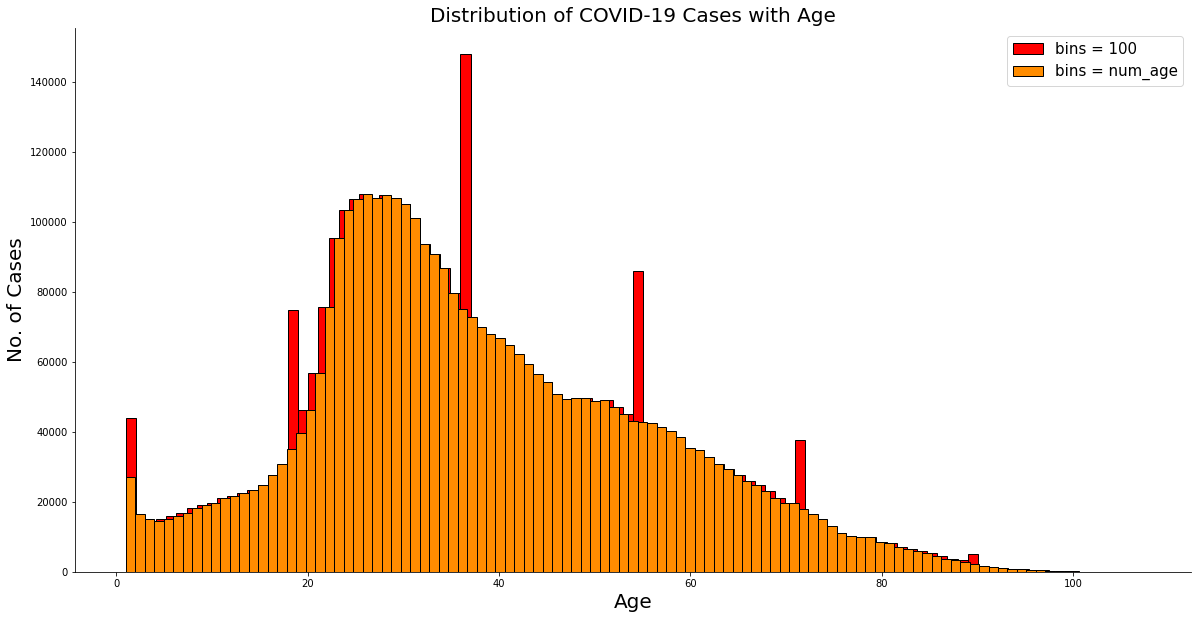

In [14]:
ax = case_data['Age'].hist(figsize = (20, 10),
                           edgecolor = 'black',
                           bins = 100,
                           color = 'red',
                           label = 'bins = 100')

case_data['Age'].hist(ax = ax,
                      figsize = (20, 10),
                      edgecolor = 'black',
                      bins = num_age,
                      color = 'darkorange',
                      label = 'bins = num_age')

ax.set_title('Distribution of COVID-19 Cases with Age', fontsize = 20)
ax.set_xlabel('Age', fontsize = 20)
ax.set_ylabel('No. of Cases', fontsize = 20)
ax.legend(fontsize = 15)

# Removing the spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.grid(False)

# Set axes label size
# plt.rcParams['axes.titlesize'] = 20
# plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

The `Sex` column can also be represented in a similar manner using a bar chart.

Text(0, 0.5, 'No. of COVID-19 Cases')

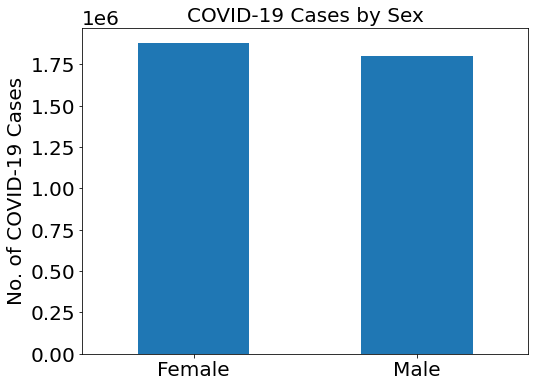

In [15]:
ax = case_data['Sex'].value_counts().plot(kind = 'bar', figsize = (8, 6))

ax.set_xticklabels(['Female', 'Male'], rotation = 0, fontsize = 20)
ax.set_title('COVID-19 Cases by Sex', fontsize = 20)
ax.set_ylabel('No. of COVID-19 Cases', fontsize = 20)

# Set axes label size
# plt.rcParams['axes.titlesize'] = 10
# plt.rcParams['axes.labelsize'] = 10
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 10

# Feature Engineering

In order to identify additional relationships regarding the dataset, additionial data must be added to the dataset using the existing features in the dataset.

## Case Registration (Temporal Data)

For this section, we wish to analyze certain features in the dataset that are related to time. Upon inspection, there are a total of six features related to time in the dataset:

- `DateSpecimen`
- `DateResultRelease`
- `DateRepConf`
- `DateDied`
- `DateRecover`
- `DateOnset`

In order to be able to make use said features, these columns must first be converted into a `datetime` object. We can transform these columns by passing them through `pandas.to_datetime()`.

In [16]:
# Converting all of the time data into pandas datetime features
case_data['DateSpecimen'] = pd.to_datetime(case_data['DateSpecimen'])
case_data['DateResultRelease'] = pd.to_datetime(case_data['DateResultRelease'])
case_data['DateRepConf'] = pd.to_datetime(case_data['DateRepConf'])
case_data['DateDied'] = pd.to_datetime(case_data['DateDied'])
case_data['DateRecover'] = pd.to_datetime(case_data['DateRecover'])
case_data['DateOnset'] = pd.to_datetime(case_data['DateOnset'])

# Validate the converted columns
case_data.dtypes

CaseCode                     object
Age                         float64
AgeGroup                     object
Sex                          object
DateSpecimen         datetime64[ns]
DateResultRelease    datetime64[ns]
DateRepConf          datetime64[ns]
DateDied             datetime64[ns]
DateRecover          datetime64[ns]
RemovalType                  object
Admitted                     object
RegionRes                    object
ProvRes                      object
CityMunRes                   object
CityMuniPSGC                 object
BarangayRes                  object
BarangayPSGC                 object
HealthStatus                 object
Quarantined                  object
DateOnset            datetime64[ns]
Pregnanttab                  object
ValidationStatus             object
dtype: object

Visualizing the all time trend of the cases in the Philippines can then be performed as shown on the plot below.

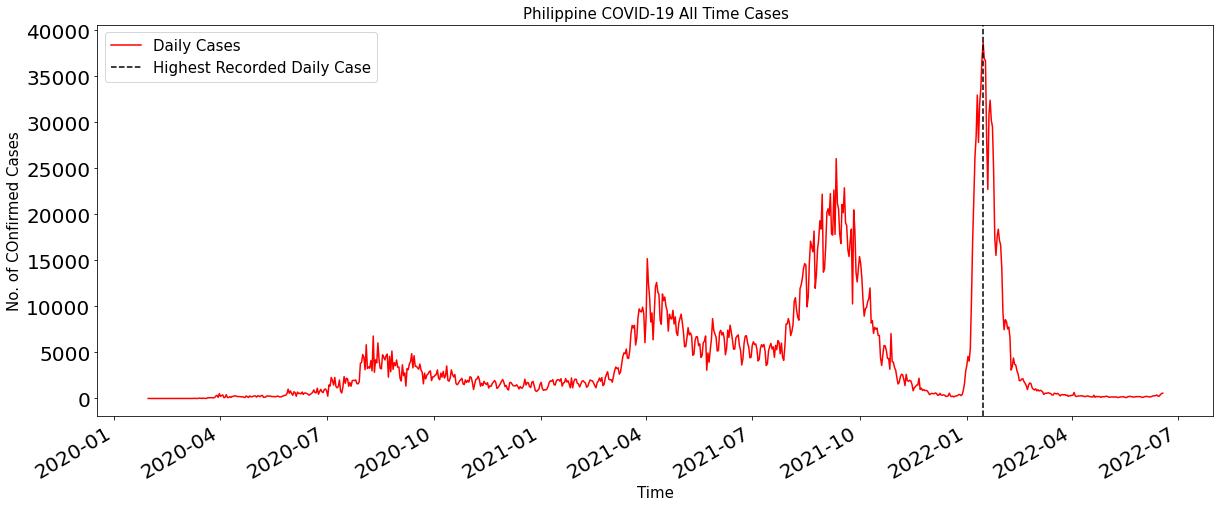

In [17]:
ax = case_data['DateRepConf'].value_counts().plot(figsize = (20, 8),
                                                 label = 'Daily Cases',
                                                 color = 'red')

ax.set_title('Philippine COVID-19 All Time Cases', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('No. of COnfirmed Cases', fontsize = 15)

ax.axvline(x = case_data['DateRepConf'].value_counts().idxmax(),
           color = 'black',
           label = 'Highest Recorded Daily Case',
           linestyle = '--')

ax.legend(fontsize = 15)

The figure above allows us to identify when the waves of COVID-19 hit the Philippines, which is characterized by the sharp increase of daily cases. Furthermore, we are also able to identify when did the country experienced its highest number of recorded cases in a single day, as indicated by the black vertical dashed line.

We can also create a graph showing the daily trend of COVID-19 related deaths that has occured in the country since the pandemic began. Comparing the graph between COVID-19 related deaths and cases would allow us to identify the correlation between the dates at which the waves of the virus has occured and its toll to the number of deaths in the country.

Text(0, 0.5, 'No. of Confirmed Deaths')

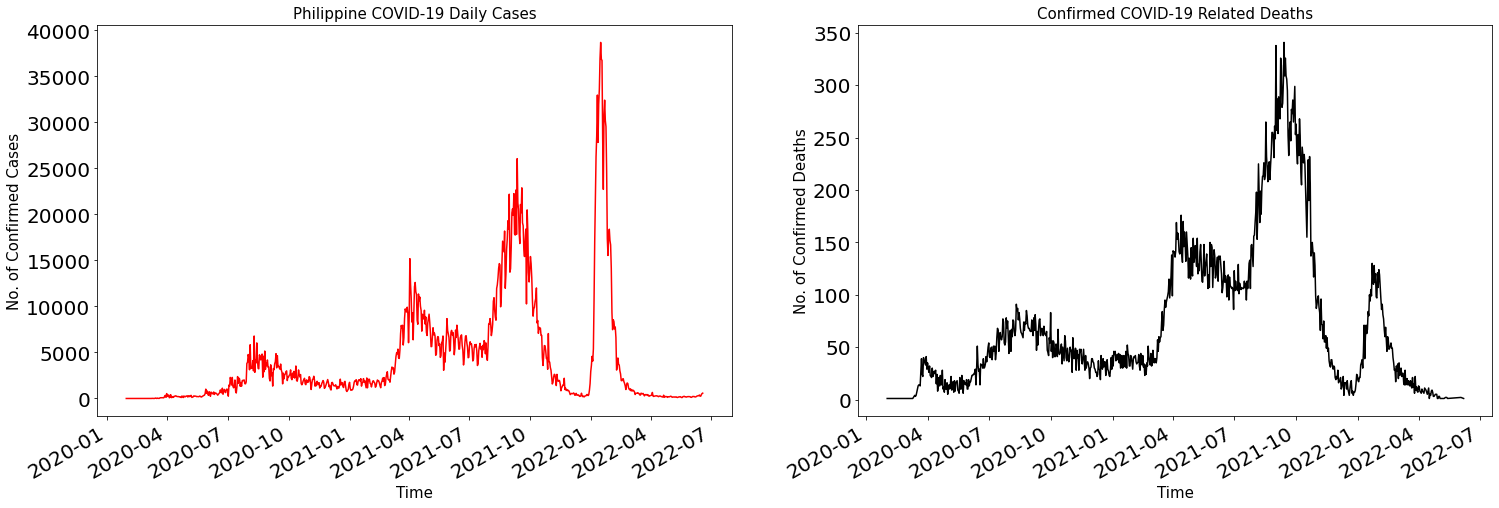

In [18]:
fig = plt.figure(figsize = (25, 8))

# add_subplot(x, y, z) x-number of rows, y-number of columns, z-which column shall the plot be placed
ax1 = fig.add_subplot(1, 2, 1)
case_data['DateRepConf'].value_counts().plot(label = 'Daily Cases', color = 'red')
ax1.set_title('Philippine COVID-19 Daily Cases', fontsize = 15)
ax1.set_xlabel('Time', fontsize = 15)
ax1.set_ylabel('No. of Confirmed Cases', fontsize = 15)

ax2 = fig.add_subplot(1, 2, 2)
case_data['DateDied'].value_counts().plot(label = 'Confirmed Deaths', color = 'black')
ax2.set_title('Confirmed COVID-19 Related Deaths', fontsize = 15)
ax2.set_xlabel('Time', fontsize = 15)
ax2.set_ylabel('No. of Confirmed Deaths', fontsize = 15)

# Problem Definitions

For this analysis the following exploratory questions shall be answered using the acquired dataset.

- Region with highest recorded case in a single day
- City/municipality with highest recorded case in a single day in NCR
- Age group with highest and lowest recorded number of cases
- Quarantined and recovered patients

Furthermore, the procedures performed in this analysis shall also prepare the dataset for further analysis using time series machine learning models.

Prior to grouping the cases per data, an additional feature must first be added to the current `DataFrame` which would act as a counter for the number of cases. In this case, `CaseCode_n` was added to the `case_data` to get the sum of cases per region on a particular date.

In [19]:
# Adding case counter
case_data['CaseCode_n'] = 1
case_data.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus,CaseCode_n
0,C404174,38.0,35 to 39,FEMALE,NaT,2020-01-30,2020-01-30,NaT,NaT,RECOVERED,...,DUMAGUETE CITY (CAPITAL),PH074610000,NaN,NaN,RECOVERED,NO,2020-01-21,NO,"Health Status is ""Recovered"", but no Date Reco...",1
1,C462688,44.0,40 to 44,MALE,NaT,2020-01-30,2020-02-03,2020-02-01,NaT,DIED,...,DUMAGUETE CITY (CAPITAL),PH074610000,NaN,NaN,DIED,NO,2020-01-18,NaN,NaN,1
2,C387710,60.0,60 to 64,FEMALE,2020-01-23,2020-01-30,2020-02-05,NaT,2020-01-31,RECOVERED,...,PANGLAO,PH071233000,NaN,NaN,RECOVERED,NO,2020-01-21,NO,Age or Birthdate is Invalid\nCase has Admittin...,1
3,C498051,63.0,60 to 64,MALE,2020-03-05,NaT,2020-03-06,2020-03-11,NaT,DIED,...,CAINTA,PH045805000,NaN,NaN,DIED,NO,NaT,NaN,"Case has Lab Result, but Result Date is blank\...",1
4,C377460,49.0,45 to 49,MALE,NaT,NaT,2020-03-06,NaT,NaT,RECOVERED,...,SANTO TOMAS,PH041028000,NaN,NaN,RECOVERED,NO,NaT,NaN,"Health Status is ""Recovered"", but no Date Reco...",1


## Region with highest recorded case in a single day

The region with the highest recorded case within a signle day can be identified by grouping the case's `DateRepConf` by its `RegionRes`. A separate `DataFrame` that contains this information would be convenient for further feature engineering.

In [20]:
# Create a separate pandas DataFrame containing the 
daily_regional_case = case_data.groupby(['DateRepConf', 'RegionRes'], as_index = False)['CaseCode_n'].sum()
daily_regional_case = daily_regional_case.rename(columns = {'DateRepConf' : 'date',
                                                            'RegionRes' : 'region',
                                                            'CaseCode_n' : 'count'})

daily_regional_case.sort_values(by = ['count'], ascending = False).head()

,date,region,count
11061,2022-01-10,NCR,18712
11151,2022-01-15,NCR,18406
11097,2022-01-12,NCR,18235
11133,2022-01-14,NCR,17055
11043,2022-01-09,NCR,17023


As shown by the sorted dates above, NCR had the highest number of recorded cases within a single day. We can plot the all time recorded cases in NCR as shown by the visualization below. The data to be used for plotting the cases within NCR only can be extracted from the `daily_regional_case` using `loc()`.

In [21]:
ncr_daily_cases = daily_regional_case.loc[daily_regional_case['region'] == 'NCR']
ncr_daily_cases = ncr_daily_cases.reset_index()
ncr_daily_cases = ncr_daily_cases.drop(columns = ['index'])
ncr_daily_cases.head()

,date,region,count
0,2020-03-08,NCR,2
1,2020-03-09,NCR,11
2,2020-03-10,NCR,7
3,2020-03-11,NCR,13
4,2020-03-12,NCR,2


Text(0.5, 0, 'Date')

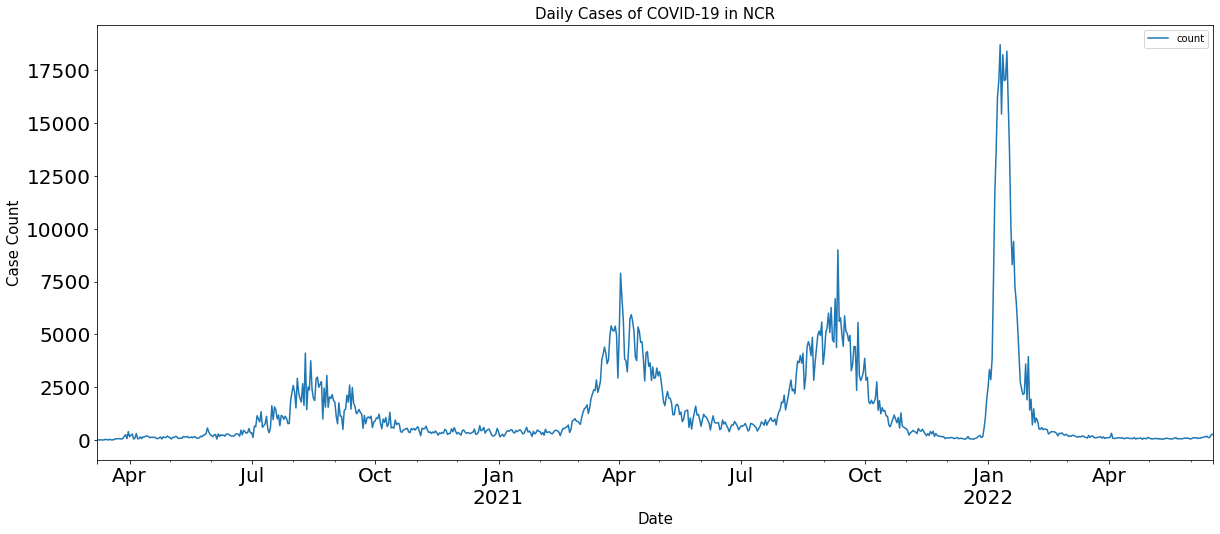

In [22]:
ax = ncr_daily_cases.plot(x = 'date', figsize = (20, 8), label = 'NCR')

ax.set_title('Daily Cases of COVID-19 in NCR', fontsize = 15)
ax.set_ylabel('Case Count', fontsize = 15)
ax.set_xlabel('Date', fontsize = 15)

Plotting the top 5 regions in the Philippines with the highest recorded amount of cases can be performed as shown by the cells below, using a similar approach for NCR.

In [23]:
daily_regional_case.groupby(['region']).sum().sort_values(by  = ['count'], ascending = False)

,count
region,
NCR,1171893
Region IV-A: CALABARZON,655063
Region III: Central Luzon,361166
Region VI: Western Visayas,194410
Region VII: Central Visayas,192582
Region II: Cagayan Valley,161322
Region XI: Davao Region,140018
Region I: Ilocos Region,133178
CAR,118586


In [24]:
# Create a separate DataFrame for each region within the top 5 number of cases, according to the cell above

r4a_daily_cases = daily_regional_case.loc[daily_regional_case['region'] == 'Region IV-A: CALABARZON']
r4a_daily_cases = r4a_daily_cases.reset_index()
r4a_daily_cases = r4a_daily_cases.drop(columns = ['index'])

r3_daily_cases = daily_regional_case.loc[daily_regional_case['region'] == 'Region III: Central Luzon']
r3_daily_cases = r3_daily_cases.reset_index()
r3_daily_cases = r3_daily_cases.drop(columns = ['index'])

r6_daily_cases = daily_regional_case.loc[daily_regional_case['region'] == 'Region VI: Western Visayas']
r6_daily_cases = r6_daily_cases.reset_index()
r6_daily_cases = r6_daily_cases.drop(columns = ['index'])

r7_daily_cases = daily_regional_case.loc[daily_regional_case['region'] == 'Region VII: Central Visayas']
r7_daily_cases = r7_daily_cases.reset_index()
r7_daily_cases = r7_daily_cases.drop(columns = ['index'])

In [25]:
ncr_daily_cases.head()

,date,region,count
0,2020-03-08,NCR,2
1,2020-03-09,NCR,11
2,2020-03-10,NCR,7
3,2020-03-11,NCR,13
4,2020-03-12,NCR,2


In [26]:
# getting the weekly granulation

ncr_weekly_cases = ncr_daily_cases.groupby(pd.Grouper(key = 'date', freq = 'W'))['count'].mean().reset_index()
ncr_weekly_cases['count'] = ncr_weekly_cases['count'].astype('int')

r4a_weekly_cases = r4a_daily_cases.groupby(pd.Grouper(key = 'date', freq = 'W'))['count'].mean().reset_index()
r4a_weekly_cases['count'] = r4a_weekly_cases['count'].astype('int')

r3_weekly_cases = r3_daily_cases.groupby(pd.Grouper(key = 'date', freq = 'W'))['count'].mean().reset_index()
r3_weekly_cases['count'] = r3_weekly_cases['count'].astype('int')

r6_weekly_cases = r6_daily_cases.groupby(pd.Grouper(key = 'date', freq = 'W'))['count'].mean().reset_index()
r6_weekly_cases['count'] = r6_weekly_cases['count'].astype('int')

r7_weekly_cases = r7_daily_cases.groupby(pd.Grouper(key = 'date', freq = 'W'))['count'].mean().reset_index()
# r7_weekly_cases['count'] = r7_weekly_cases['count'].astype('int')

r7_weekly_cases.head()

,date,count
0,2020-02-02,1.0
1,2020-02-09,1.0
2,2020-02-16,NaN
3,2020-02-23,NaN
4,2020-03-01,NaN


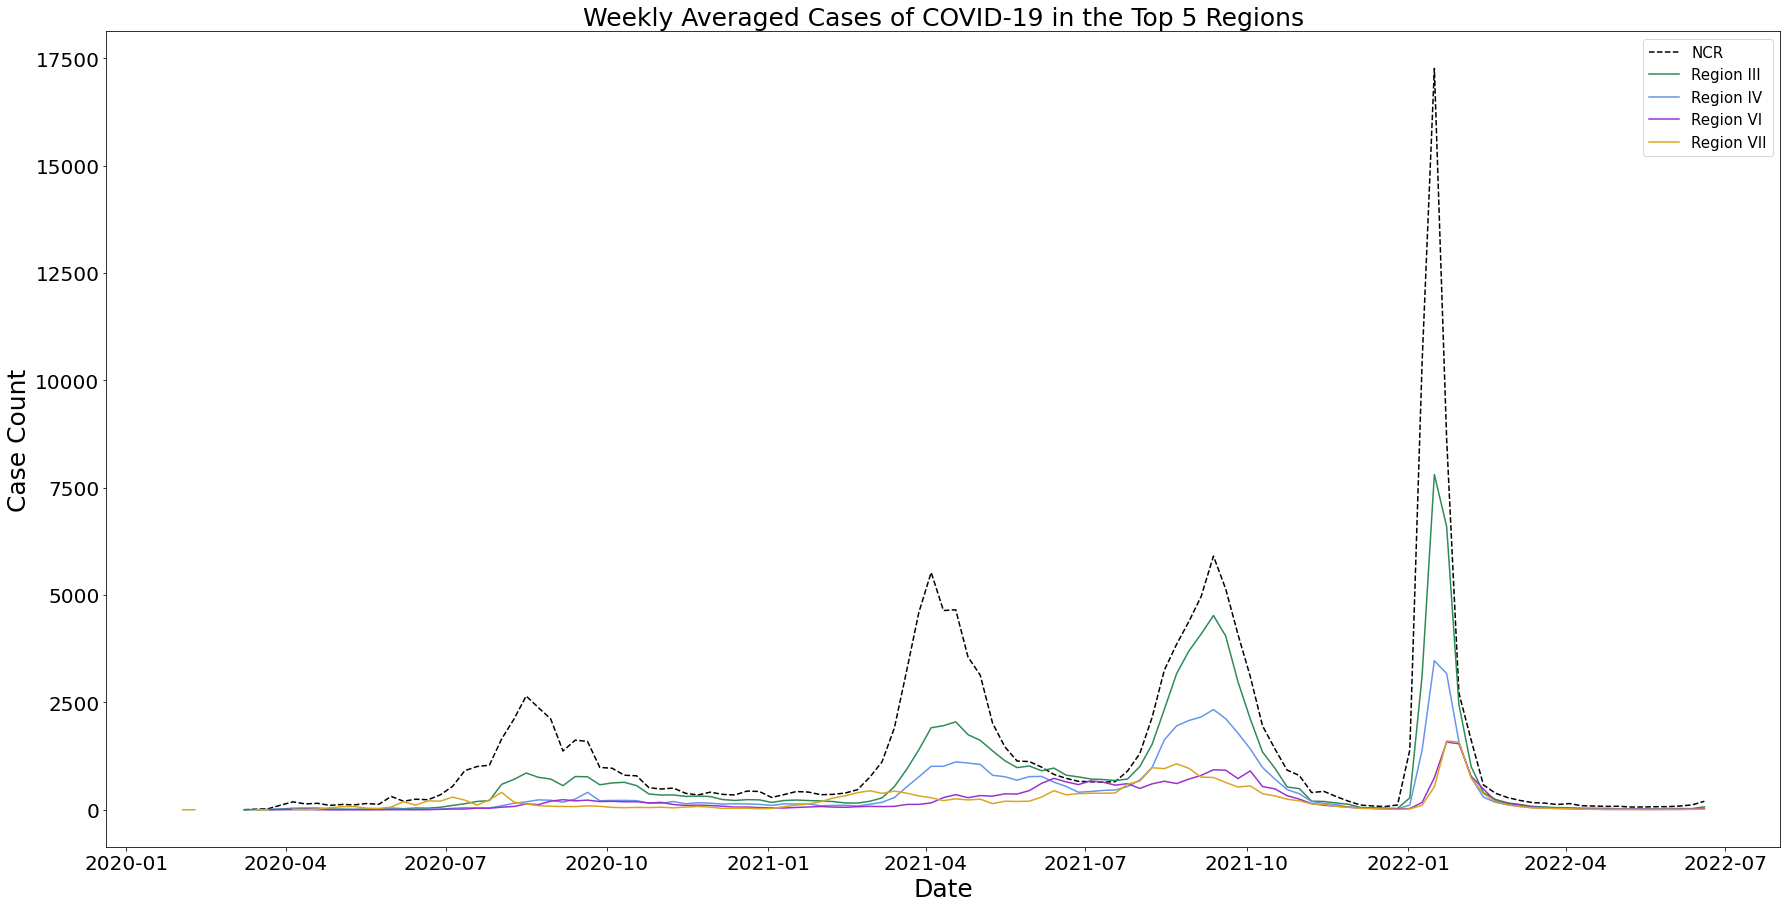

In [27]:
# Plotting the data
plt.figure(figsize = (30, 15))

plt.plot(ncr_weekly_cases['date'], ncr_weekly_cases['count'], label = 'NCR', linestyle = '--', color = 'black')

plt.plot(r4a_weekly_cases['date'], r4a_weekly_cases['count'], label = 'Region III', color = 'seagreen')
plt.plot(r3_weekly_cases['date'], r3_weekly_cases['count'], label = 'Region IV', color = 'cornflowerblue')
plt.plot(r6_weekly_cases['date'], r6_weekly_cases['count'], label = 'Region VI', color = 'darkorchid')
plt.plot(r7_weekly_cases['date'], r7_weekly_cases['count'], label = 'Region VII', color = 'goldenrod')

plt.title('Weekly Averaged Cases of COVID-19 in the Top 5 Regions', fontsize = 25)
plt.ylabel('Case Count', fontsize = 25)
plt.xlabel('Date', fontsize = 25)

plt.legend(fontsize = 15)

## City/municipality with the highest recorded amount of cases in the NCR within a single day

Using a similar approach, the city within NCR with the highset recorded number of cases within a single day can also be identified. Cases that are exclusively in NCR, however, must first be extracted using `loc()`

In [28]:
ncr_city_cases = case_data.loc[case_data['RegionRes'] == 'NCR'].reset_index()
ncr_city_cases = ncr_city_cases.drop(columns = ['index'])
ncr_city_cases.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus,CaseCode_n
0,C178743,39.0,35 to 39,MALE,2020-03-06,2020-03-08,2020-03-08,NaT,2020-03-21,RECOVERED,...,CITY OF MAKATI,PH137602000,NaN,NaN,RECOVERED,YES,2020-03-03,NaN,Age or Birthdate is Invalid,1
1,C557002,86.0,80+,MALE,2020-03-06,2020-03-08,2020-03-08,2020-03-14,NaT,DIED,...,CITY OF MARIKINA,PH137402000,NaN,NaN,DIED,NO,2020-03-01,NaN,Age or Birthdate is Invalid,1
2,C261719,57.0,55 to 59,MALE,2020-03-07,2020-03-09,2020-03-09,2020-03-15,NaT,DIED,...,CITY OF MANILA,PH133906000,NaN,NaN,DIED,NO,NaT,NaN,NaN,1
3,C985840,51.0,50 to 54,FEMALE,2020-03-07,2020-03-09,2020-03-09,NaT,NaT,RECOVERED,...,CITY OF SAN JUAN,PH137405000,NaN,NaN,RECOVERED,NO,2020-03-04,NO,"Age or Birthdate is Invalid\nRemoval Type is ""...",1
4,C557823,41.0,40 to 44,MALE,NaT,NaT,2020-03-09,NaT,2020-03-24,RECOVERED,...,CITY OF PASIG,PH137403000,NaN,NaN,RECOVERED,NO,NaT,NaN,Age or Birthdate is Invalid,1


In [29]:
ncr_city_cases.shape

(1171893, 23)

In [30]:
ncr_city_cases.isna().sum()

CaseCode                   0
Age                        0
AgeGroup                   0
Sex                        0
DateSpecimen          315597
DateResultRelease     313098
DateRepConf                0
DateDied             1159032
DateRecover           919546
RemovalType             1856
Admitted              859546
RegionRes                  0
ProvRes                 5571
CityMunRes              7977
CityMuniPSGC            7977
BarangayRes           153444
BarangayPSGC          153417
HealthStatus               0
Quarantined              139
DateOnset             993942
Pregnanttab           582458
ValidationStatus      182436
CaseCode_n                 0
dtype: int64

Given that a total of 7977 cases within NCR was not assigned to a `CityMunRes`, a certain margin of error should be expected with the number of cases acquired from this analysis, compared to the actual reported number of cases reported by the DOH.

In [31]:
daily_ncr_city_case = ncr_city_cases.groupby(['DateRepConf', 'CityMunRes'], as_index = False)['CaseCode_n'].sum()
daily_ncr_city_case = daily_ncr_city_case.rename(columns = {'DateRepConf' : 'date',
                                                            'CityMunRes' : 'city',
                                                            'CaseCode_n' : 'count'})
daily_ncr_city_case.sort_values(by = ['count'], ascending = False).head()

,date,city,count
10909,2022-01-10,QUEZON CITY,4784
10943,2022-01-12,QUEZON CITY,4312
10977,2022-01-14,QUEZON CITY,4025
10994,2022-01-15,QUEZON CITY,3901
10960,2022-01-13,QUEZON CITY,3792


In [32]:
daily_ncr_city_case.groupby(['city']).sum().sort_values(by  = ['count'], ascending = False)

,count
city,
QUEZON CITY,244453
CITY OF MANILA,147469
CITY OF PASIG,84984
TAGUIG CITY,83618
CALOOCAN CITY,83306
CITY OF MAKATI,83195
CITY OF PARAÑAQUE,71189
PASAY CITY,52853
CITY OF LAS PIÑAS,50735


It can be identified that Quezon City had the most number of recorded cases in a single day, which occured in January 10, 2022. Visualizing the trend of the COVID-19 cases in Quezon City can be performed as shown using a similar method that was used for the daily trend in NCR.

In [33]:
daily_quezon_case = daily_ncr_city_case.loc[daily_ncr_city_case['city'] == 'QUEZON CITY']
daily_quezon_case = daily_quezon_case.reset_index()
daily_quezon_case = daily_quezon_case.drop(columns = ['index'])
daily_quezon_case.head()

,date,city,count
0,2020-03-09,QUEZON CITY,1
1,2020-03-11,QUEZON CITY,2
2,2020-03-12,QUEZON CITY,1
3,2020-03-13,QUEZON CITY,1
4,2020-03-14,QUEZON CITY,11


Text(0.5, 0, 'Date')

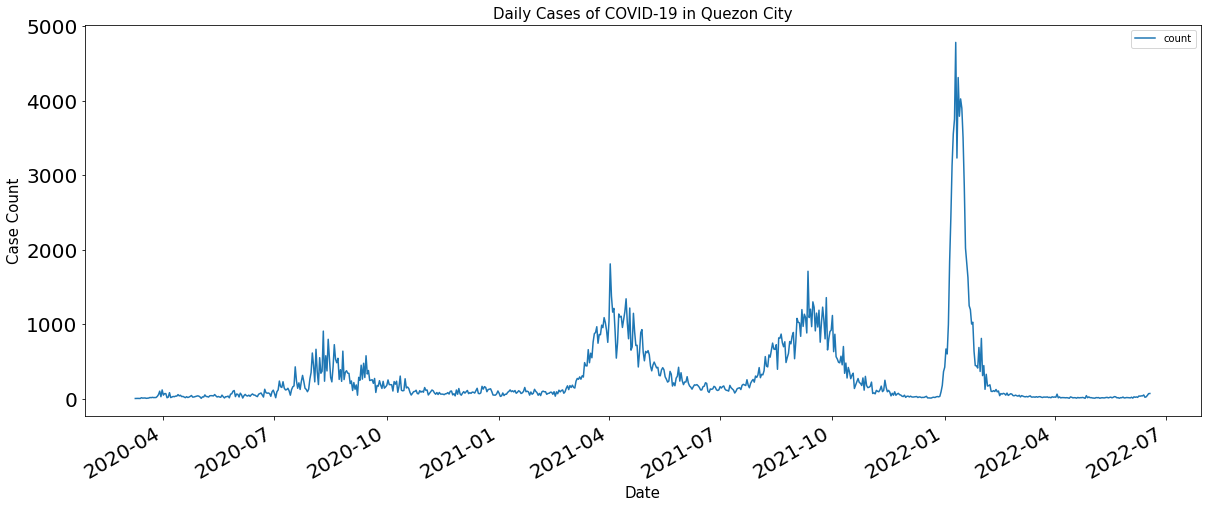

In [34]:
ax = daily_quezon_case.plot(x = 'date', figsize = (20, 8), label = "Quezon City")

ax.set_title('Daily Cases of COVID-19 in Quezon City', fontsize = 15)
ax.set_ylabel('Case Count', fontsize = 15)
ax.set_xlabel('Date', fontsize = 15)


The top 5 cities within NCR that had the highest number of recorded cases can also be identified as shown below. Their corresponding case trends can also be visualized.

In [35]:
daily_ncr_city_case.groupby(['city']).sum().sort_values(by  = ['count'], ascending = False)

,count
city,
QUEZON CITY,244453
CITY OF MANILA,147469
CITY OF PASIG,84984
TAGUIG CITY,83618
CALOOCAN CITY,83306
CITY OF MAKATI,83195
CITY OF PARAÑAQUE,71189
PASAY CITY,52853
CITY OF LAS PIÑAS,50735


In [36]:
# Create a separate DataFrame for each city within the top 5 number of cases in NCR, according to the cell above

daily_manila_case = daily_ncr_city_case.loc[daily_ncr_city_case['city'] == 'CITY OF MANILA']
daily_manila_case = daily_manila_case.reset_index()
daily_manila_case = daily_manila_case.drop(columns = ['index'])

daily_pasig_case = daily_ncr_city_case.loc[daily_ncr_city_case['city'] == 'CITY OF PASIG']
daily_pasig_case = daily_pasig_case.reset_index()
daily_pasig_case = daily_pasig_case.drop(columns = ['index'])

daily_taguig_case = daily_ncr_city_case.loc[daily_ncr_city_case['city'] == 'TAGUIG CITY']
daily_taguig_case = daily_taguig_case.reset_index()
daily_taguig_case = daily_taguig_case.drop(columns = ['index'])

daily_caloocan_case = daily_ncr_city_case.loc[daily_ncr_city_case['city'] == 'CALOOCAN CITY']
daily_caloocan_case = daily_caloocan_case.reset_index()
daily_caloocan_case = daily_caloocan_case.drop(columns = ['index'])

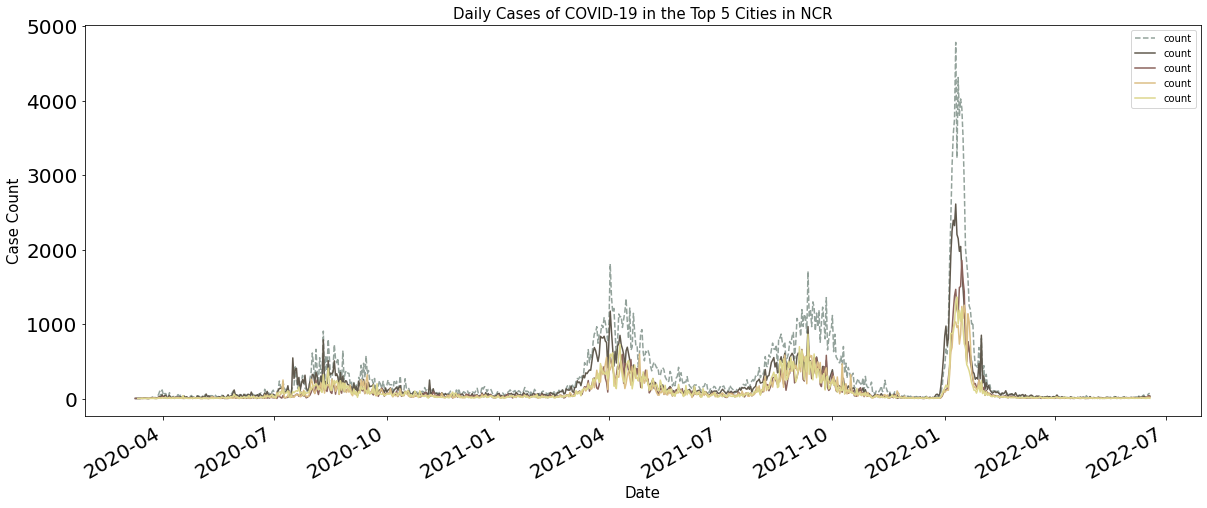

In [37]:
ax = daily_quezon_case.plot(x = 'date', figsize = (20, 8), label = 'Quezon City', linestyle = '--', color = '#93A29B')

daily_manila_case.plot(ax = ax, x = 'date', label = 'Region III', color = '#60594D')
daily_pasig_case.plot(ax = ax, x = 'date', label = 'Region IV', color = '#8B635C')
daily_taguig_case.plot(ax = ax, x = 'date', label = 'Region VI', color = '#DCBF85')
daily_caloocan_case.plot(ax = ax, x = 'date', label = 'Region VII', color = '#DDD78D')

ax.set_title('Daily Cases of COVID-19 in the Top 5 Cities in NCR', fontsize = 15)
ax.set_ylabel('Case Count', fontsize = 15)
ax.set_xlabel('Date', fontsize = 15)

ax.legend()

## Age group with highest and lowest recorded number of cases

It would be ideal to determine the number of cases per age group and its relation to the number of deaths that have occured to identify the most vulnerable age groups to COVID-19. Identifying which age group is most susceptible to the virus can help recommend which target groups should be prioritized for vaccination.

The number of cases present in the dataset can be grouped using `groupby()` to create another `DataFrame` containing the number of cases per age group.

In [38]:
cases_age_group = case_data.groupby(['AgeGroup'])['CaseCode_n'].sum()
cases_age_group = cases_age_group.rename_axis('AgeGroup').reset_index(name = 'Counts')

#Correcting the arrangement
new_index = [0, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13 ,14, 15, 16]

cases_age_group = cases_age_group.reindex(new_index)
cases_age_group = cases_age_group.reset_index()
cases_age_group = cases_age_group.drop(columns = 'index')
cases_age_group = cases_age_group.rename(columns = {'AgeGroup' : 'agegroup', 'Counts' : 'casecount'})
cases_age_group.head(20)

,agegroup,casecount
0,0 to 4,73420
1,5 to 9,85193
2,10 to 14,108687
3,15 to 19,158184
4,20 to 24,377363
5,25 to 29,535685
6,30 to 34,477451
7,35 to 39,365556
8,40 to 44,309601
9,45 to 49,253694


The same procedure can be applied to determine the number of deaths per age group within the data.

In [39]:
case_data.HealthStatus.value_counts()

RECOVERED       3614182
DIED              60088
MILD               1916
ASYMPTOMATIC       1660
MODERATE            404
SEVERE              123
CRITICAL             43
Name: HealthStatus, dtype: int64

In [40]:
case_deaths = case_data.loc[case_data['HealthStatus'] == 'DIED']
case_deaths.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus,CaseCode_n
1,C462688,44.0,40 to 44,MALE,NaT,2020-01-30,2020-02-03,2020-02-01,NaT,DIED,...,DUMAGUETE CITY (CAPITAL),PH074610000,NaN,NaN,DIED,NO,2020-01-18,NaN,NaN,1
3,C498051,63.0,60 to 64,MALE,2020-03-05,NaT,2020-03-06,2020-03-11,NaT,DIED,...,CAINTA,PH045805000,NaN,NaN,DIED,NO,NaT,NaN,"Case has Lab Result, but Result Date is blank\...",1
5,C130591,58.0,55 to 59,FEMALE,2020-03-06,2020-03-07,2020-03-07,2020-03-12,NaT,DIED,...,CAINTA,PH045805000,NaN,NaN,DIED,NO,NaT,NO,Age or Birthdate is Invalid,1
8,C557002,86.0,80+,MALE,2020-03-06,2020-03-08,2020-03-08,2020-03-14,NaT,DIED,...,CITY OF MARIKINA,PH137402000,NaN,NaN,DIED,NO,2020-03-01,NaN,Age or Birthdate is Invalid,1
11,C261719,57.0,55 to 59,MALE,2020-03-07,2020-03-09,2020-03-09,2020-03-15,NaT,DIED,...,CITY OF MANILA,PH133906000,NaN,NaN,DIED,NO,NaT,NaN,NaN,1


In [41]:
# Arrange deaths by age group and number of counts
deaths_age_group = case_deaths.groupby(['AgeGroup'])['CaseCode_n'].sum()
deaths_age_group = deaths_age_group.rename_axis('AgeGroup').reset_index(name = 'Counts')

#Correcting the arrangement
new_index = [0, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13 ,14, 15, 16]

deaths_age_group = deaths_age_group.reindex(new_index)
deaths_age_group = deaths_age_group.reset_index()
deaths_age_group = deaths_age_group.drop(columns = 'index')
deaths_age_group = deaths_age_group.rename(columns = {'AgeGroup' : 'agegroup', 'Counts' : 'casecount'})
deaths_age_group.head(20)

,agegroup,casecount
0,0 to 4,317
1,5 to 9,120
2,10 to 14,191
3,15 to 19,305
4,20 to 24,580
5,25 to 29,1047
6,30 to 34,1396
7,35 to 39,1794
8,40 to 44,2472
9,45 to 49,3365


Text(0, 0.5, 'No. of Deaths')

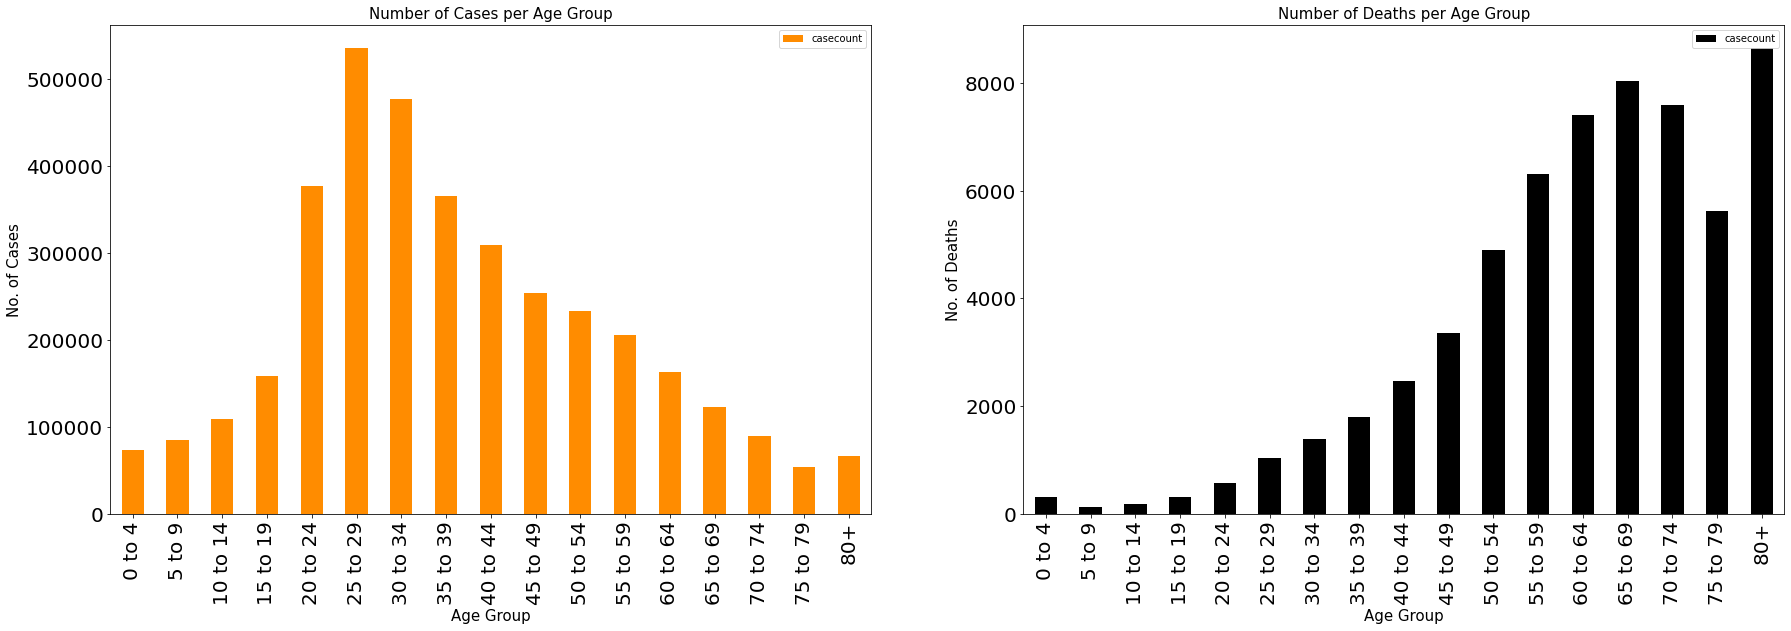

In [42]:
fig = plt.figure(figsize = (30, 9))

# add_subplot(x, y, z) x-number of rows, y-number of columns, z-which column shall the plot be placed
ax1 = fig.add_subplot(1, 2, 1)
cases_age_group.plot(ax = ax1, x = 'agegroup', kind = 'bar', label = 'Cases', color = 'darkorange')
ax1.set_title('Number of Cases per Age Group', fontsize = 15)
ax1.set_xlabel('Age Group', fontsize = 15)
ax1.set_ylabel('No. of Cases', fontsize = 15)
# ax1.set_xticklabels(labels = cases_age_group['agegroup'], rotation = 0)

ax2 = fig.add_subplot(1, 2, 2)
deaths_age_group.plot(ax = ax2, x = 'agegroup', kind = 'bar', label = 'Cases', color = 'black')
ax2.set_title('Number of Deaths per Age Group', fontsize = 15)
ax2.set_xlabel('Age Group', fontsize = 15)
ax2.set_ylabel('No. of Deaths', fontsize = 15)
# ax2.set_xticklabels



## Quarantined and recovered patients

For convenience, a separate `DataFrame` shall be made which contains the patients which are reported to have been recovered or quarantined.

In [43]:
case_data['HealthStatus'].value_counts()

RECOVERED       3614182
DIED              60088
MILD               1916
ASYMPTOMATIC       1660
MODERATE            404
SEVERE              123
CRITICAL             43
Name: HealthStatus, dtype: int64

Identifying the date which had the most number of recoveries from covid can be peroformed using the cell below.

In [44]:
recovered_cases = case_data.loc[case_data['HealthStatus'] == 'RECOVERED']
recovered_cases = recovered_cases.groupby(['DateRecover'], as_index = True)['CaseCode_n'].sum()
recovered_cases = recovered_cases.rename_axis('date').reset_index(name = 'counts')

#Sorting the number of recovered cases per day
recovered_cases.sort_values(by = ['counts'], ascending = False)

,date,counts
694,2022-01-24,5758
691,2022-01-21,4936
695,2022-01-25,4839
702,2022-02-01,4715
692,2022-01-22,4446
...,...,...
14,2020-03-14,1
4,2020-03-04,1
3,2020-03-03,1
2,2020-03-02,1


We can then identify that the Philippines had the most number of recoveries on January 24, 2022. A plot can aslo be created which shows the trend of recovered cases as shown below.

Text(0, 0.5, 'No. of Recovered Cases')

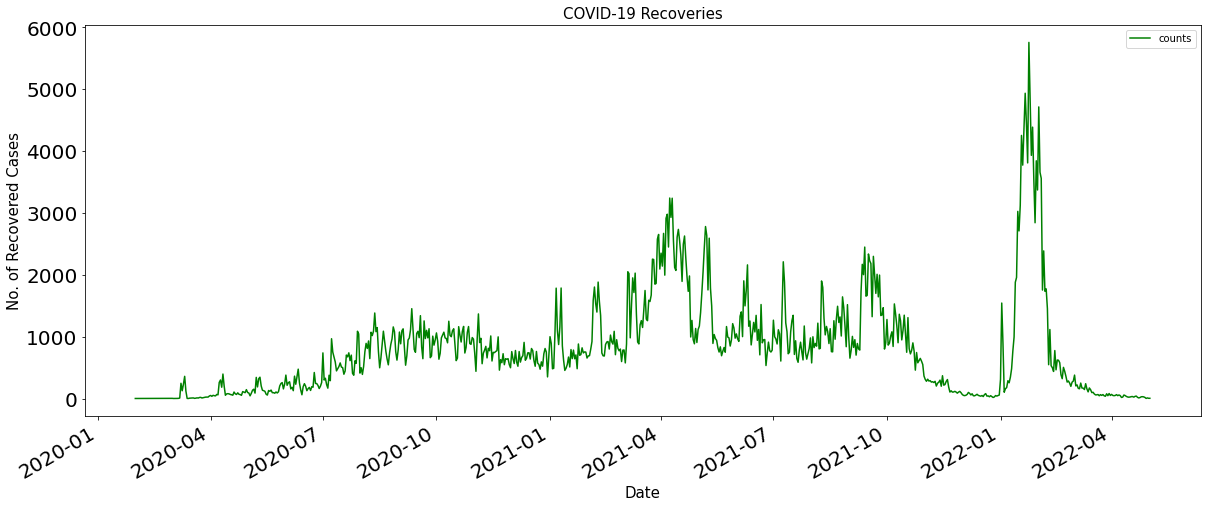

In [45]:
ax = recovered_cases.plot(x = 'date', color = 'green', figsize = (20, 8))
ax.set_title('COVID-19 Recoveries', fontsize = 15)
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('No. of Recovered Cases', fontsize = 15)

Due to certain limitations within the available data provided DOH, the `DateSpecimen` shall be used which marks the date at which the patient was quarantined. Cases which were quarantined can be extracted in a similar manner, as shown below.

In [46]:
case_data['Quarantined'].value_counts()

NO     3100288
YES     577987
Name: Quarantined, dtype: int64

In [47]:
quarantined_cases = case_data.loc[case_data['Quarantined'] == 'YES']
quarantined_cases = quarantined_cases.groupby(['DateSpecimen'], as_index = True)['CaseCode_n'].sum()
quarantined_cases = quarantined_cases.rename_axis('date').reset_index(name = 'counts')

#Sorting the number of recovered cases per day
quarantined_cases.sort_values(by = ['counts'], ascending = False)

,date,counts
671,2022-01-05,3690
565,2021-09-21,3640
566,2021-09-22,3452
670,2022-01-04,3352
672,2022-01-06,3138
...,...,...
782,2022-04-27,4
766,2022-04-10,4
775,2022-04-19,3
2,2020-03-07,3


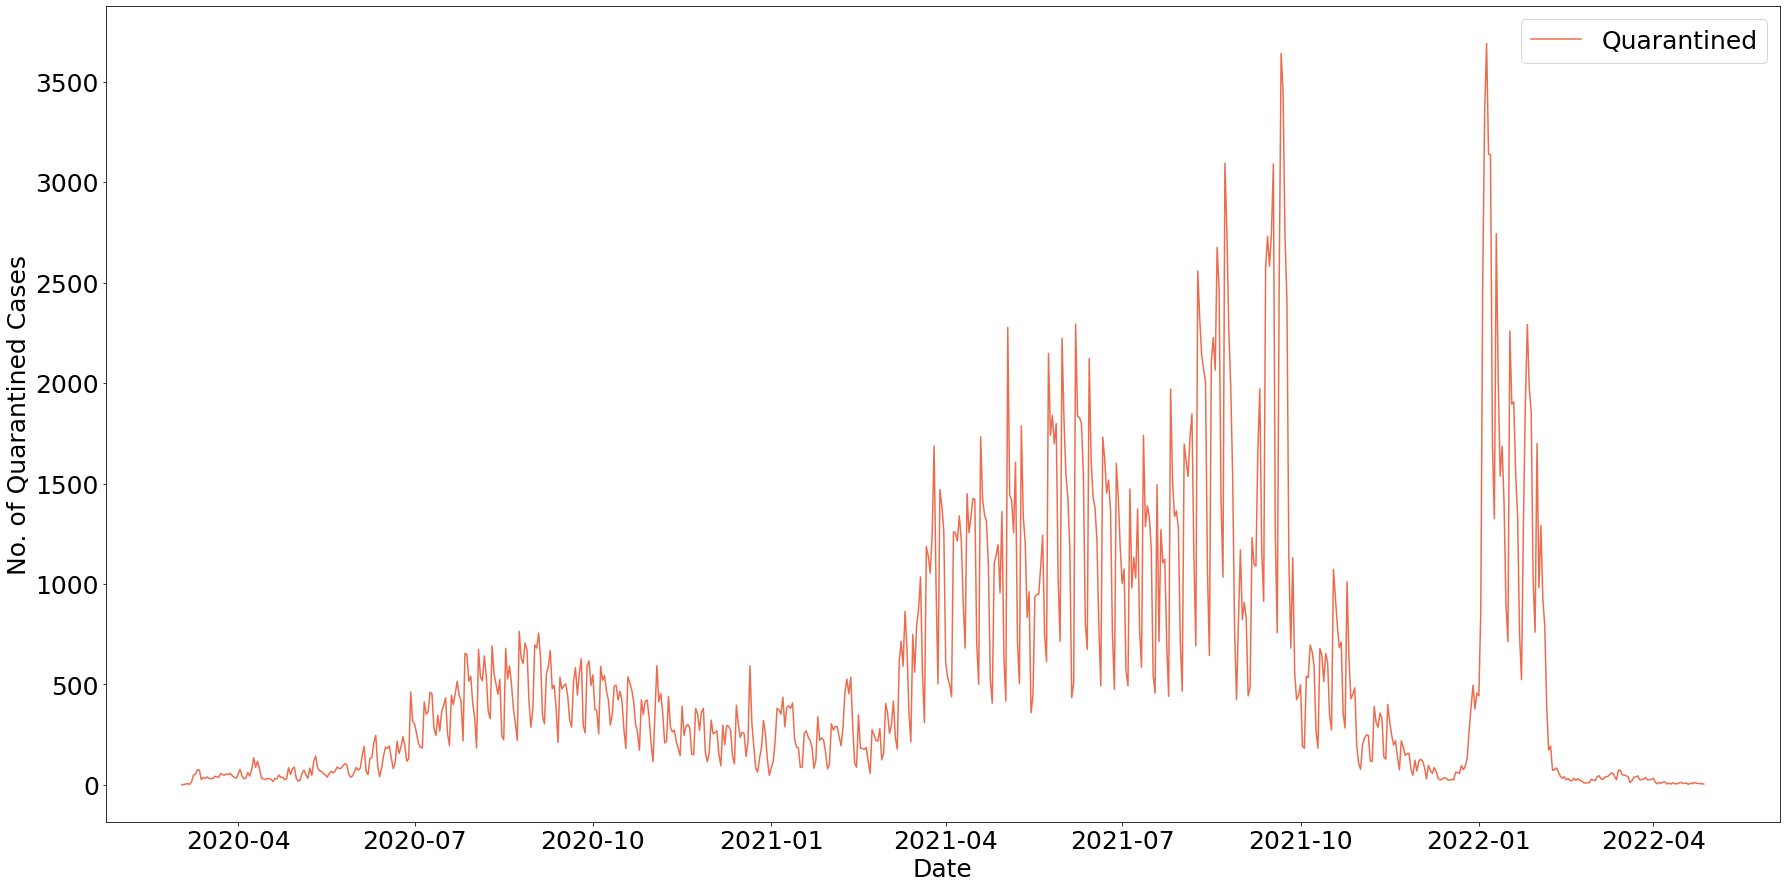

In [48]:
plt.figure(figsize = (30, 15))

plt.plot(quarantined_cases['date'],
         quarantined_cases['counts'],
         label = 'Quarantined',
         color = '#EE6C4D')

plt.legend(fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Quarantined Cases', fontsize = 25);

The graph which shows the trend in recoveries can be improved by decreasing the granularity of the graph to a weekly basis.

In [49]:
weekly_quarantined_cases = quarantined_cases.groupby(pd.Grouper(key = 'date', freq = 'W'))['counts'].mean().reset_index()
weekly_quarantined_cases['counts'] = weekly_quarantined_cases['counts'].astype('int')
weekly_quarantined_cases.head()

,date,counts
0,2020-03-08,6
1,2020-03-15,49
2,2020-03-22,36
3,2020-03-29,52
4,2020-04-05,44


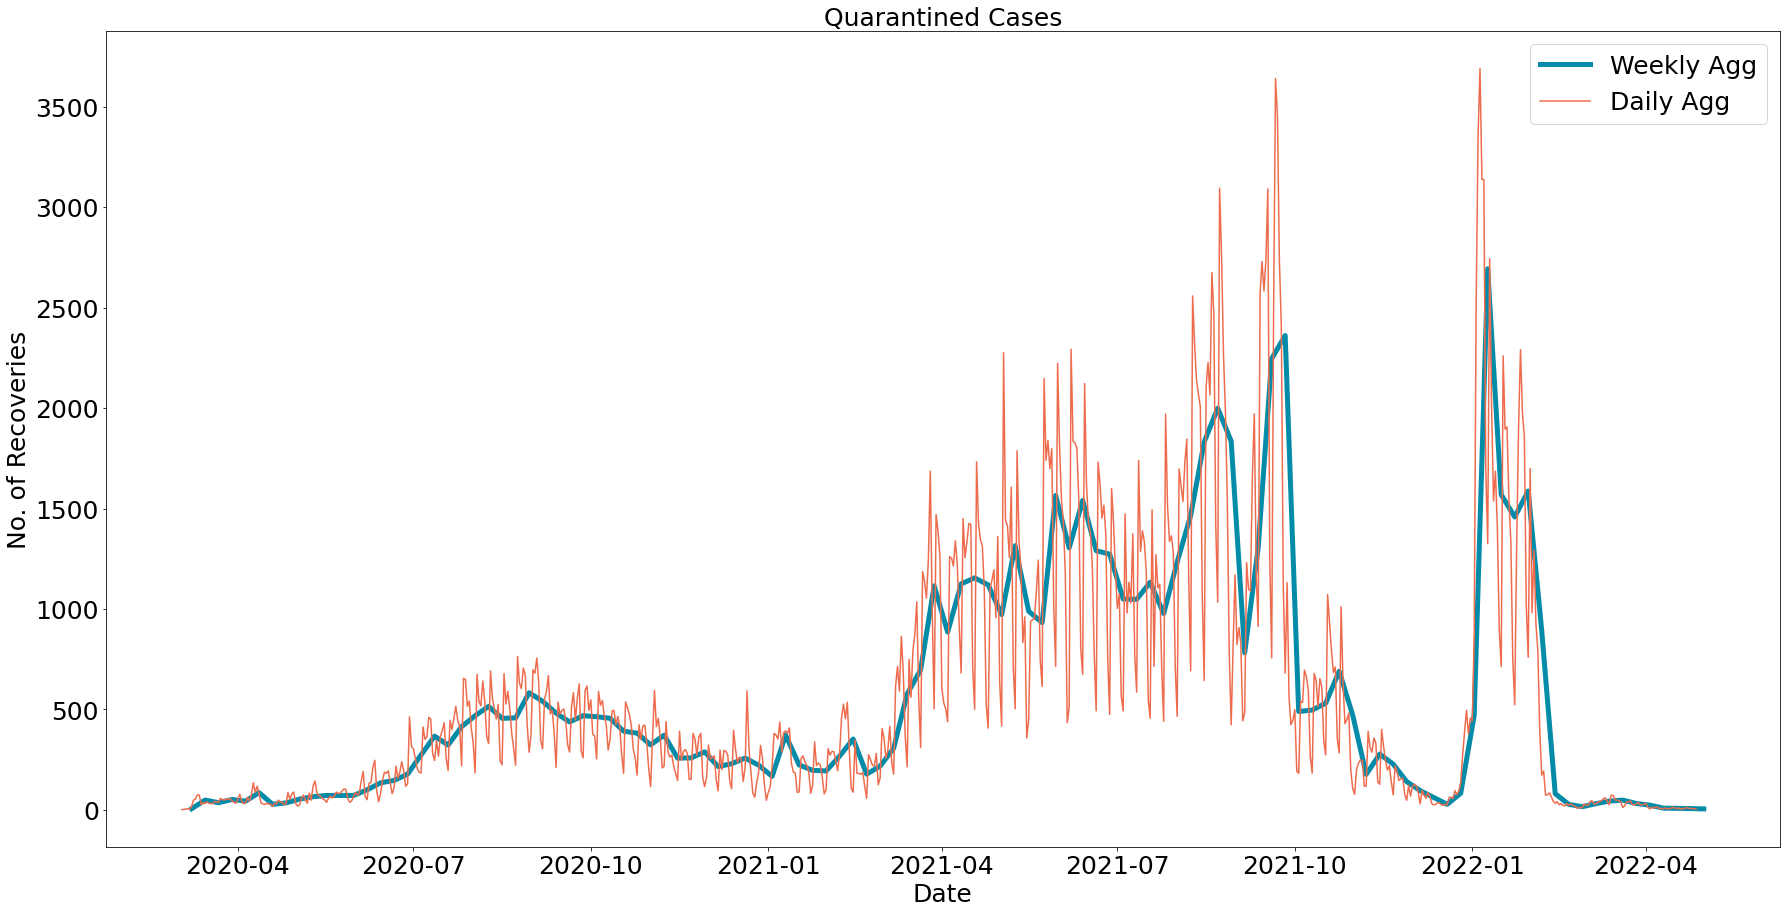

In [50]:
plt.figure(figsize = (30, 15))

# Plotting the recoveries at a weekly and daily granularity
plt.plot(weekly_quarantined_cases['date'],
         weekly_quarantined_cases['counts'],
         label = 'Weekly Agg',
         linewidth = 5,
         color = '#048BA8')

plt.plot(quarantined_cases['date'],
         quarantined_cases['counts'],
         label = 'Daily Agg',
         color = '#EE6C4D')

plt.legend(fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.title('Quarantined Cases', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Recoveries', fontsize = 25);

# Philippine COVID-19 Geographical Data Analysis

## NOTE: The Geographical Analysis is already transferred to a separate notebook.

Since we have identified that certain regions and cities in the country are more likely to have a greater number of cases compared to others, it would be helpful to create heatmaps to identify the COVID hotspots in the country.

Using the provided PSGC column in the `doh_data` dataset, we can pinpoint the geographical location of the cases in the country to create a heatmap. However, further datasets containing the latitude and longitude of a certain PSGC code must be collected. The PSGC shape files were provided by **altcoder** which was placed in the data folder for this analysis.

Philippines PSGC Administrative Boundaries Shapefiles: https://github.com/altcoder/philippines-psgc-shapefiles

In [51]:
case_data[['CityMuniPSGC', 'BarangayPSGC']]

,CityMuniPSGC,BarangayPSGC
0,PH074610000,NaN
1,PH074610000,NaN
2,PH071233000,NaN
3,PH045805000,NaN
4,PH041028000,NaN
...,...,...
695647,PH137602000,PH137602002
695648,PH021529000,PH021529039
695649,PH064515000,PH064515008
695650,PH175306000,NaN


In [52]:
print('Number of Missing Municipal PSGC Data: ', case_data['CityMuniPSGC'].isna().sum())
print('Number of Missing Barangay PSGC Data: ', case_data['BarangayPSGC'].isna().sum())

Number of Missing Municipal PSGC Data:  58248
Number of Missing Barangay PSGC Data:  312951


Since there is a significant number of null values for the barangay and municipal columns for each recorded observations, it would be ideal not to drop these rows. A separate observation can be implemented for these values regarding their geographical data.

## Municipal Level Analysis

The shape data provided can includes the following shape files at various LGU levels.

- Barangays
- Municipalities
- Provinces
- Regions
- Country

The shape file at a municipal level can be read as follows.


### Reading the shape files

In [53]:
muni_shape = gpd.read_file('data/Project/Municipalities/Municities.shp')
muni_shape.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

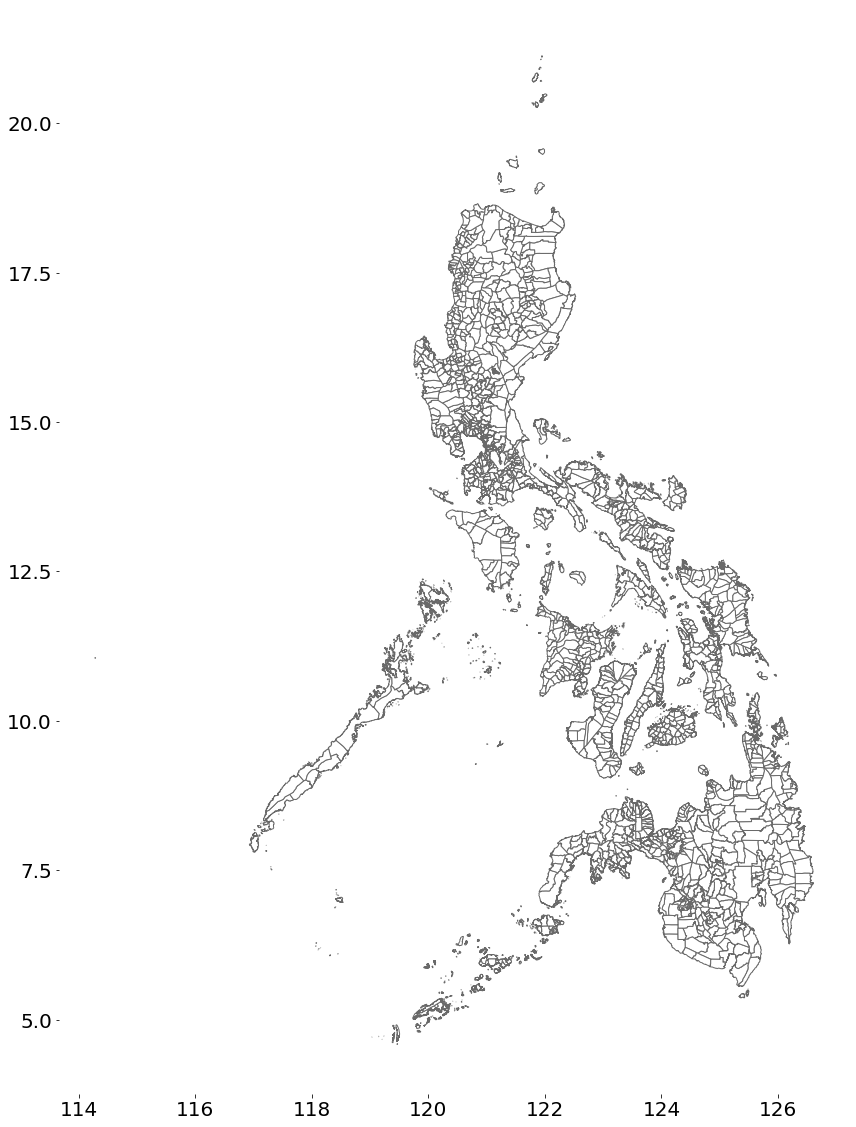

In [54]:
# Test plot
ax = muni_shape.plot(figsize = (30, 20), color = 'white', edgecolor = 'dimgrey')

# Removing the spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [55]:
case_data.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus,CaseCode_n
0,C404174,38.0,35 to 39,FEMALE,NaT,2020-01-30,2020-01-30,NaT,NaT,RECOVERED,...,DUMAGUETE CITY (CAPITAL),PH074610000,NaN,NaN,RECOVERED,NO,2020-01-21,NO,"Health Status is ""Recovered"", but no Date Reco...",1
1,C462688,44.0,40 to 44,MALE,NaT,2020-01-30,2020-02-03,2020-02-01,NaT,DIED,...,DUMAGUETE CITY (CAPITAL),PH074610000,NaN,NaN,DIED,NO,2020-01-18,NaN,NaN,1
2,C387710,60.0,60 to 64,FEMALE,2020-01-23,2020-01-30,2020-02-05,NaT,2020-01-31,RECOVERED,...,PANGLAO,PH071233000,NaN,NaN,RECOVERED,NO,2020-01-21,NO,Age or Birthdate is Invalid\nCase has Admittin...,1
3,C498051,63.0,60 to 64,MALE,2020-03-05,NaT,2020-03-06,2020-03-11,NaT,DIED,...,CAINTA,PH045805000,NaN,NaN,DIED,NO,NaT,NaN,"Case has Lab Result, but Result Date is blank\...",1
4,C377460,49.0,45 to 49,MALE,NaT,NaT,2020-03-06,NaT,NaT,RECOVERED,...,SANTO TOMAS,PH041028000,NaN,NaN,RECOVERED,NO,NaT,NaN,"Health Status is ""Recovered"", but no Date Reco...",1


In [56]:
muni_case_geodata = case_data[['CaseCode', 'CaseCode_n', 'DateRepConf', 'DateDied', 'DateRecover', 'CityMunRes', 'CityMuniPSGC', 'HealthStatus']]
muni_case_geodata.head()

,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,CityMunRes,CityMuniPSGC,HealthStatus
0,C404174,1,2020-01-30,NaT,NaT,DUMAGUETE CITY (CAPITAL),PH074610000,RECOVERED
1,C462688,1,2020-02-03,2020-02-01,NaT,DUMAGUETE CITY (CAPITAL),PH074610000,DIED
2,C387710,1,2020-02-05,NaT,2020-01-31,PANGLAO,PH071233000,RECOVERED
3,C498051,1,2020-03-06,2020-03-11,NaT,CAINTA,PH045805000,DIED
4,C377460,1,2020-03-06,NaT,NaT,SANTO TOMAS,PH041028000,RECOVERED


Upon inspection, various PSGC codes are available in the shape file. Manual inspection allows us to identify that columns that are labelled with ADM3 are related to the geographical data at a municipal level. Said columns related to the shape data can then be extracted as shown below

In [57]:
muni_shape.head()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,0.423604,0.009506,Adams,PH012801000,None,None,None,Ilocos Norte,PH012800000,Region I,PH010000000,Philippines (the),PH,2016-06-15,2018-01-30,None,"POLYGON ((120.94626 18.51158, 120.96915 18.510..."
1,0.309136,0.004725,Bacarra,PH012802000,None,None,None,Ilocos Norte,PH012800000,Region I,PH010000000,Philippines (the),PH,2016-06-15,2018-01-30,None,"POLYGON ((120.59081 18.29526, 120.59192 18.295..."
2,0.599295,0.006880,Badoc,PH012803000,None,None,None,Ilocos Norte,PH012800000,Region I,PH010000000,Philippines (the),PH,2016-06-15,2018-01-30,None,"POLYGON ((120.47783 17.97744, 120.47780 17.977..."
3,0.482911,0.009843,Bangui,PH012804000,None,None,None,Ilocos Norte,PH012800000,Region I,PH010000000,Philippines (the),PH,2016-06-15,2018-01-30,None,"POLYGON ((120.79393 18.53475, 120.79537 18.534..."
4,0.613500,0.013493,City of Batac,PH012805000,None,None,None,Ilocos Norte,PH012800000,Region I,PH010000000,Philippines (the),PH,2016-06-15,2018-01-30,None,"POLYGON ((120.56070 18.12259, 120.56088 18.122..."


In [58]:
muni_shape.columns

Index(['Shape_Leng', 'Shape_Area', 'ADM3_EN', 'ADM3_PCODE', 'ADM3_REF',
       'ADM3ALT1EN', 'ADM3ALT2EN', 'ADM2_EN', 'ADM2_PCODE', 'ADM1_EN',
       'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn', 'validTo',
       'geometry'],
      dtype='object')

In [59]:
muni_shape = muni_shape[['Shape_Leng', 'Shape_Area', 'ADM3_EN', 'ADM3_PCODE', 'geometry']]
muni_shape = muni_shape.rename(columns = {'ADM3_EN' : 'city',
                                          'ADM3_PCODE' : 'city_psgc',
                                          'ADM2_EN' : 'region',
                                          'ADM2_PCODE' : 'region_psgc'})
muni_shape.head()

,Shape_Leng,Shape_Area,city,city_psgc,geometry
0,0.423604,0.009506,Adams,PH012801000,"POLYGON ((120.94626 18.51158, 120.96915 18.510..."
1,0.309136,0.004725,Bacarra,PH012802000,"POLYGON ((120.59081 18.29526, 120.59192 18.295..."
2,0.599295,0.006880,Badoc,PH012803000,"POLYGON ((120.47783 17.97744, 120.47780 17.977..."
3,0.482911,0.009843,Bangui,PH012804000,"POLYGON ((120.79393 18.53475, 120.79537 18.534..."
4,0.613500,0.013493,City of Batac,PH012805000,"POLYGON ((120.56070 18.12259, 120.56088 18.122..."


In order to plot the heatmap, the `geometry` column from `muni_shape` must be extracted and assigned to its respective PSGC in `muni_case_geodata`. The said operation can be performed by looping thorugh each of the grouped cases by municipalities and checks the shape data by looping again through the PSGC column of the shape data for comparison. If the loop deems that the PSGC from `muni_case_geodata` is equivalent to `muni_shape`, the corresponding geometry data is transferred to the `muni_case_geodata`

In [60]:
muni_case_geodata = muni_case_geodata.groupby(['CityMuniPSGC', 'CityMunRes'], as_index = True)['CaseCode_n'].sum()
muni_case_geodata = muni_case_geodata.reset_index(name = 'counts')
muni_case_geodata.head()

,CityMuniPSGC,CityMunRes,counts
0,PH012801000,ADAMS,94
1,PH012802000,BACARRA,1524
2,PH012803000,BADOC,755
3,PH012804000,BANGUI,1296
4,PH012805000,CITY OF BATAC,3654


In [61]:
# Double for loop to compare both dataframes
case_geometry = pd.DataFrame(columns = ['geometry'])
i = 0
for x in muni_case_geodata['CityMuniPSGC']:
  for y, z, a, b in zip(muni_shape['city_psgc'], muni_shape['geometry'], muni_shape['Shape_Leng'], muni_shape['Shape_Area']):
    if x == y:
      case_geometry = case_geometry.append({'city_psgc' : x,'geometry' : z, 'Shape_Leng' : a, 'Shape_Area' : b}, ignore_index = True)

c:\users\adria\appdata\local\programs\python\python39\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [62]:
case_geometry.head()

,geometry,Shape_Area,Shape_Leng,city_psgc
0,POLYGON ((120.94625672200004 18.51157559700004...,0.009506,0.423604,PH012801000
1,POLYGON ((120.59081476600011 18.29526317800002...,0.004725,0.309136,PH012802000
2,POLYGON ((120.47782670000004 17.97743741100004...,0.006880,0.599295,PH012803000
3,POLYGON ((120.79392524700017 18.53474835600008...,0.009843,0.482911,PH012804000
4,POLYGON ((120.5606964750001 18.122593537000057...,0.013493,0.613500,PH012805000


In [63]:
case_geometry = case_geometry.rename(columns = {'city_psgc' : 'CityMuniPSGC'})
muni_case_geodata = muni_case_geodata.merge(case_geometry, how = 'inner', on = 'CityMuniPSGC')
muni_case_geodata.head()

,CityMuniPSGC,CityMunRes,counts,geometry,Shape_Area,Shape_Leng
0,PH012801000,ADAMS,94,POLYGON ((120.94625672200004 18.51157559700004...,0.009506,0.423604
1,PH012802000,BACARRA,1524,POLYGON ((120.59081476600011 18.29526317800002...,0.004725,0.309136
2,PH012803000,BADOC,755,POLYGON ((120.47782670000004 17.97743741100004...,0.006880,0.599295
3,PH012804000,BANGUI,1296,POLYGON ((120.79392524700017 18.53474835600008...,0.009843,0.482911
4,PH012805000,CITY OF BATAC,3654,POLYGON ((120.5606964750001 18.122593537000057...,0.013493,0.613500


In [64]:
muni_case_geodata = gpd.GeoDataFrame(muni_case_geodata)
type(muni_case_geodata)

geopandas.geodataframe.GeoDataFrame

(116.44505944095008, 127.08877065205004, 3.760564947900073, 21.948615028100072)

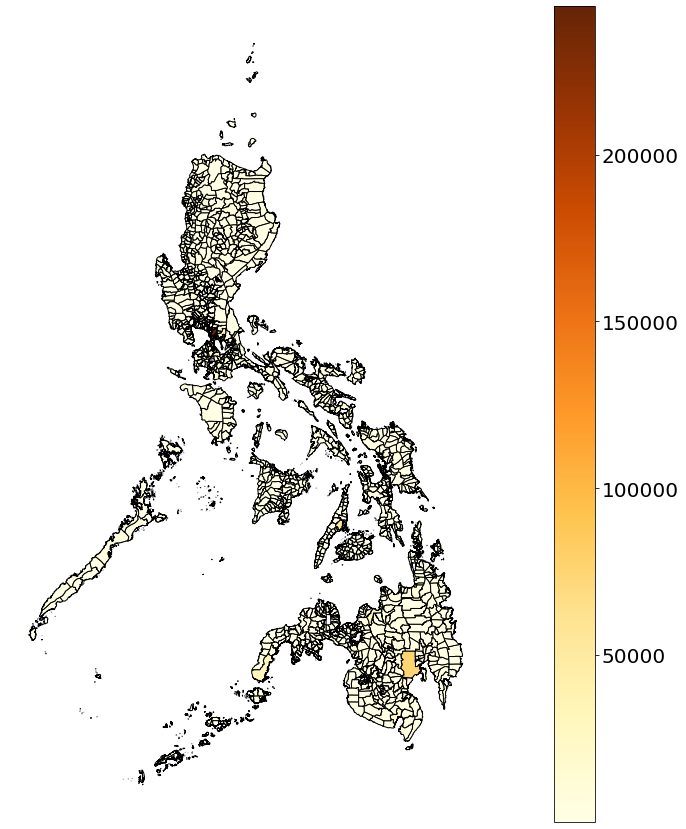

In [65]:
fig = plt.figure(figsize = (25, 15))
ax = fig.add_subplot(1, 1, 1)

muni_case_geodata.plot(ax = ax,
                       cmap=plt.cm.YlOrBr,
                       legend = True,
                       edgecolor = 'black',
                       column = 'counts',
                       missing_kwds={
                        "color": "lightgrey",
                        "edgecolor": "red",
                        "hatch": "///",
                        "label": "Missing values",})
ax.axis(False)

In [66]:
muni_case_geodata.sort_values(by = ['counts'], ascending = False).head(10)

,CityMuniPSGC,CityMunRes,counts,geometry,Shape_Area,Shape_Leng
1234,PH137404000,QUEZON CITY,244453,"POLYGON ((121.13497 14.77673, 121.13447 14.776...",0.013630,0.773902
1233,PH137403000,CITY OF PASIG,84984,"POLYGON ((121.08469 14.62389, 121.08579 14.622...",0.002626,0.344848
1246,PH137607000,TAGUIG CITY,83618,"POLYGON ((121.08105 14.54749, 121.08109 14.547...",0.002988,0.358176
1236,PH137501000,CALOOCAN CITY,83306,"MULTIPOLYGON (((121.01856 14.69176, 121.01867 ...",0.004468,0.692758
1241,PH137602000,CITY OF MAKATI,83195,"POLYGON ((121.03468 14.56725, 121.03521 14.567...",0.002094,0.260317
1131,PH112402000,DAVAO CITY,74729,"POLYGON ((125.54361 7.56545, 125.54331 7.54805...",0.191718,2.808307
1243,PH137604000,CITY OF PARAÑAQUE,71189,"POLYGON ((120.99814 14.53308, 120.99883 14.532...",0.003758,0.431594
769,PH072217000,CEBU CITY (CAPITAL),56100,"MULTIPOLYGON (((123.90442 10.27218, 123.90376 ...",0.024016,0.803569
1244,PH137605000,PASAY CITY,52853,"POLYGON ((120.98042 14.56156, 120.98043 14.561...",0.001500,0.262552
1240,PH137601000,CITY OF LAS PIÑAS,50735,"MULTIPOLYGON (((120.98122 14.48720, 120.98120 ...",0.002745,0.362306


As shown on the choropleth map, the number of cases that have occured in different cities in the Philippines pales into comparison with the cities located in NCR. A separate analysis for the cities in NCR would thus be ideal to determine certain hotpots within the region.

## NCR and Barangay Level Analysis

To narrow the scope of the DataFrame to what is needed for this part of the Exploratory Data Analysis, a new DataFrame object will be created based on the filtering done to baran_datashape limite the data to only ones from the NCR Region. This new DataFrame will be called NCR_datashape. The barangay shapefiles can be read as shown on the cell below.

In [67]:
# Reading the shapefile
baran_shape = gpd.read_file('data/Project/Barangays/Barangays.shp')
baran_shape.head()

,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_PCODE,ADM3_EN,ADM4_PCODE,ADM4_EN,geometry
0,PH010000000,REGION I (ILOCOS REGION),PH015500000,PANGASINAN,PH015502000,AGUILAR,PH015502012,Pogomboa,"POLYGON ((120.25441 15.88112, 120.24723 15.878..."
1,PH010000000,REGION I (ILOCOS REGION),PH015500000,PANGASINAN,PH015502000,AGUILAR,PH015502013,Pogonsili,"POLYGON ((120.26372 15.81724, 120.25821 15.811..."
2,PH010000000,REGION I (ILOCOS REGION),PH015500000,PANGASINAN,PH015502000,AGUILAR,PH015502014,San Jose,"POLYGON ((120.28018 15.87048, 120.27885 15.870..."
3,PH010000000,REGION I (ILOCOS REGION),PH015500000,PANGASINAN,PH015502000,AGUILAR,PH015502016,Tampac,"POLYGON ((120.26163 15.87600, 120.26149 15.875..."
4,PH010000000,REGION I (ILOCOS REGION),PH015500000,PANGASINAN,PH015502000,AGUILAR,PH015502017,Laoag,"POLYGON ((120.22100 15.88999, 120.22163 15.886..."


In [68]:
baran_shape.ADM1_EN.unique()

array(['REGION I (ILOCOS REGION)', 'REGION II (CAGAYAN VALLEY)',
       'REGION III (CENTRAL LUZON)', 'REGION IV-A (CALABARZON)',
       'REGION V (BICOL REGION)', 'REGION VI (WESTERN VISAYAS)',
       'REGION VII (CENTRAL VISAYAS)', 'REGION VIII (EASTERN VISAYAS)',
       'REGION IX (ZAMBOANGA PENINSULA)', 'REGION X (NORTHERN MINDANAO)',
       'REGION XI (DAVAO REGION)', 'REGION XII (SOCCSKSARGEN)',
       'NATIONAL CAPITAL REGION (NCR)',
       'CORDILLERA ADMINISTRATIVE REGION (CAR)',
       'AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)',
       'REGION XIII (Caraga)', 'REGION IV-B (MIMAROPA)',
       'NEGROS ISLAND REGION (NIR)'], dtype=object)

<AxesSubplot:>

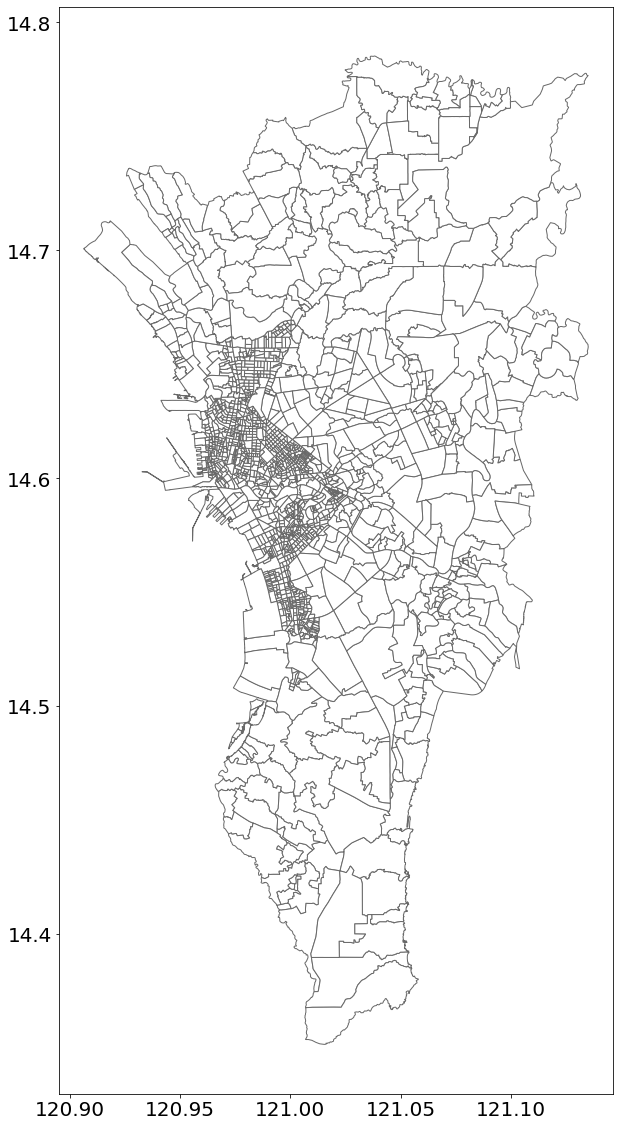

In [69]:
# Check Plot
baran_shape.loc[baran_shape['ADM1_EN'] == 'NATIONAL CAPITAL REGION (NCR)'].plot(figsize = (30, 20),
                                                                                color = 'white',
                                                                                edgecolor = 'dimgrey')

In [70]:
ncr_shape = baran_shape.loc[baran_shape['ADM1_EN'] == 'NATIONAL CAPITAL REGION (NCR)']
ncr_shape.head()

,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_PCODE,ADM3_EN,ADM4_PCODE,ADM4_EN,geometry
32685,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901009,Barangay 9,"POLYGON ((120.97051 14.60673, 120.96993 14.606..."
32686,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901010,Barangay 10,"POLYGON ((120.97086 14.60589, 120.97075 14.605..."
32687,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901011,Barangay 11,"POLYGON ((120.96686 14.60185, 120.96671 14.601..."
32688,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901012,Barangay 12,"POLYGON ((120.96635 14.60135, 120.96632 14.601..."
32689,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901013,Barangay 13,"POLYGON ((120.96635 14.60356, 120.96643 14.603..."


Next, the same process shall be done to the data on the COVID-19 cases, with only select columns to be used later. This new `DataFrame` will be labelled as `ncr_case_data`.

In [71]:
case_data.columns

Index(['CaseCode', 'Age', 'AgeGroup', 'Sex', 'DateSpecimen',
       'DateResultRelease', 'DateRepConf', 'DateDied', 'DateRecover',
       'RemovalType', 'Admitted', 'RegionRes', 'ProvRes', 'CityMunRes',
       'CityMuniPSGC', 'BarangayRes', 'BarangayPSGC', 'HealthStatus',
       'Quarantined', 'DateOnset', 'Pregnanttab', 'ValidationStatus',
       'CaseCode_n'],
      dtype='object')

In [72]:
ncr_case_geodata = case_data.loc[case_data['ProvRes'] == 'NCR']
ncr_case_geodata = ncr_case_geodata[['CaseCode', 'CaseCode_n', 'DateRepConf', 'DateDied', 'DateRecover', 'BarangayRes', 'CityMunRes', 'BarangayPSGC', 'HealthStatus']]
ncr_case_geodata.head()

,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,BarangayRes,CityMunRes,BarangayPSGC,HealthStatus
7,C178743,1,2020-03-08,NaT,2020-03-21,NaN,CITY OF MAKATI,NaN,RECOVERED
8,C557002,1,2020-03-08,2020-03-14,NaT,NaN,CITY OF MARIKINA,NaN,DIED
11,C261719,1,2020-03-09,2020-03-15,NaT,NaN,CITY OF MANILA,NaN,DIED
12,C985840,1,2020-03-09,NaT,NaT,NaN,CITY OF SAN JUAN,NaN,RECOVERED
13,C557823,1,2020-03-09,NaT,2020-03-24,NaN,CITY OF PASIG,NaN,RECOVERED


In [73]:
ncr_case_geodata = ncr_case_geodata.groupby([ 'CityMunRes', 'BarangayPSGC', 'BarangayRes'], as_index = True)['CaseCode_n'].sum()
ncr_case_geodata = ncr_case_geodata.reset_index(name = 'case_count')
ncr_case_geodata.head()

,CityMunRes,BarangayPSGC,BarangayRes,case_count
0,CALOOCAN CITY,PH137501001,BARANGAY 1,554
1,CALOOCAN CITY,PH137501002,BARANGAY 2,274
2,CALOOCAN CITY,PH137501003,BARANGAY 3,171
3,CALOOCAN CITY,PH137501004,BARANGAY 4,158
4,CALOOCAN CITY,PH137501005,BARANGAY 5,143


A similar methodology in extracting the geometry column from `baran_shape` using a nested for loop to append the data to `ncr_case_geodata` shall be applied to plot the map the corresponding COVID-19 choropleth map in NCR.

In [74]:
# ncr_case_geometry = pd.DataFrame(columns = ['geometry'])
# # i = 0
# for x in NCR_case_test['BarangayPSGC']:
#   for y, z, a, b in zip(NCR_datashape['BarangayPSGC'], NCR_datashape['geometry'], NCR_datashape['PERIMETER'], NCR_datashape['AREA']):
#     if x == y:
#       case_geometry = case_geometry.append({'BarangayPSGC' : x,'geometry' : z, 'PERIMETER' : a, 'AREA' : b}, ignore_index = True)
# print(case_geometry.columns);
# print(case_geometry.shape)

In [75]:
ncr_shape.head()

,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_PCODE,ADM3_EN,ADM4_PCODE,ADM4_EN,geometry
32685,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901009,Barangay 9,"POLYGON ((120.97051 14.60673, 120.96993 14.606..."
32686,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901010,Barangay 10,"POLYGON ((120.97086 14.60589, 120.97075 14.605..."
32687,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901011,Barangay 11,"POLYGON ((120.96686 14.60185, 120.96671 14.601..."
32688,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901012,Barangay 12,"POLYGON ((120.96635 14.60135, 120.96632 14.601..."
32689,PH130000000,NATIONAL CAPITAL REGION (NCR),PH133900000,"NCR, CITY OF MANILA, FIRST DISTRICT (Not a Pro...",PH133901000,TONDO I / II,PH133901013,Barangay 13,"POLYGON ((120.96635 14.60356, 120.96643 14.603..."


It is important that the number of unqiue PSGC codes on both datasets are equal for the loop to work

In [76]:
len(ncr_shape.ADM4_PCODE.unique())

1707

In [77]:
len(ncr_case_geodata.BarangayPSGC.unique())

1707

In [78]:
# # Double for loop to compare both dataframes
# case_geometry = pd.DataFrame(columns = ['geometry'])
# i = 0
# for x in muni_case_geodata['CityMuniPSGC']:
#   for y, z, a, b in zip(muni_shape['city_psgc'], muni_shape['geometry'], muni_shape['Shape_Leng'], muni_shape['Shape_Area']):
#     if x == y:
#       case_geometry = case_geometry.append({'city_psgc' : x,'geometry' : z, 'Shape_Leng' : a, 'Shape_Area' : b}, ignore_index = True)

In [79]:
# Double for loop to compare both dataframes
ncr_case_geometry = pd.DataFrame(columns = ['geometry'])
i = 0
for x in ncr_case_geodata['BarangayPSGC']:
  for y, z, a, in zip(ncr_shape['ADM4_PCODE'], ncr_shape['geometry'], ncr_shape['ADM4_EN']):
    if x == y:
      ncr_case_geometry = ncr_case_geometry.append({'BarangayPSGC' : x,'geometry' : z, 'barangay' : a}, ignore_index = True)

c:\users\adria\appdata\local\programs\python\python39\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [80]:
ncr_case_geometry.head()

,geometry,BarangayPSGC,barangay
0,POLYGON ((120.97384002000001 14.65750298500006...,PH137501001,Barangay 1
1,POLYGON ((120.97343876700006 14.66192315200004...,PH137501002,Barangay 2
2,POLYGON ((120.97277513200004 14.65758987300006...,PH137501003,Barangay 3
3,POLYGON ((120.97073220300001 14.65973005100005...,PH137501004,Barangay 4
4,POLYGON ((120.97277513200004 14.65758987300006...,PH137501005,Barangay 5


Finally, both `ncr_case_geometry` and `ncr_case_geodata` can then be merged to plot the choropleth map of the COVID-19 cases in NCR.

In [81]:
ncr_case_geodata = ncr_case_geodata.merge(ncr_case_geometry, how = 'inner', on = 'BarangayPSGC')
ncr_case_geodata.head()

,CityMunRes,BarangayPSGC,BarangayRes,case_count,geometry,barangay
0,CALOOCAN CITY,PH137501001,BARANGAY 1,554,POLYGON ((120.97384002000001 14.65750298500006...,Barangay 1
1,CALOOCAN CITY,PH137501002,BARANGAY 2,274,POLYGON ((120.97343876700006 14.66192315200004...,Barangay 2
2,CALOOCAN CITY,PH137501003,BARANGAY 3,171,POLYGON ((120.97277513200004 14.65758987300006...,Barangay 3
3,CALOOCAN CITY,PH137501004,BARANGAY 4,158,POLYGON ((120.97073220300001 14.65973005100005...,Barangay 4
4,CALOOCAN CITY,PH137501005,BARANGAY 5,143,POLYGON ((120.97277513200004 14.65758987300006...,Barangay 5


In [82]:
ncr_case_geodata = gpd.GeoDataFrame(ncr_case_geodata)
type(ncr_case_geodata)

geopandas.geodataframe.GeoDataFrame

(120.89496338290007, 121.14646846310006, 14.330051460000053, 14.80696983600006)

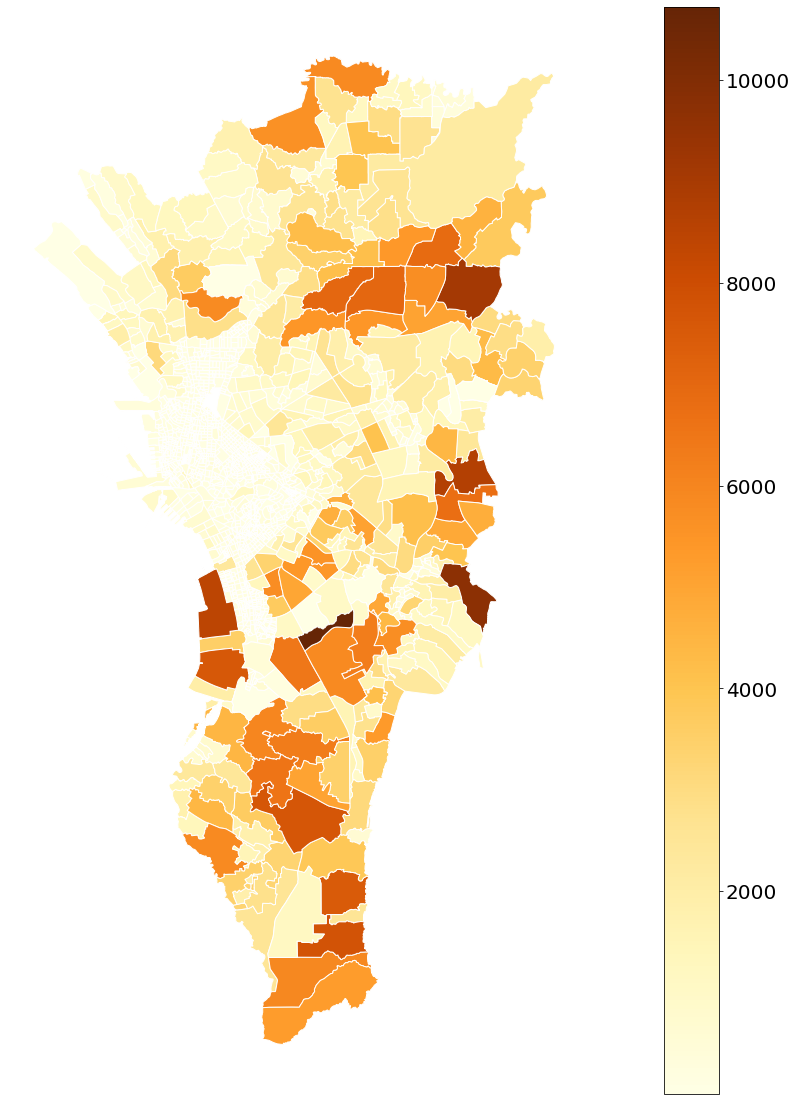

In [83]:
fig = plt.figure(figsize = (30, 20))
ax = fig.add_subplot(1, 1, 1)

ncr_case_geodata.plot(ax = ax,
                      cmap=plt.cm.YlOrBr,
                      legend = True,
                      edgecolor = 'white',
                      column = 'case_count',
                      missing_kwds={
                        "color": "lightgrey",
                        "edgecolor": "red",
                        "hatch": "///",
                        "label": "Missing values",})
ax.axis(False)

In [84]:
ncr_case_geodata.sort_values(by = 'case_count', ascending = False).head(5)

,CityMunRes,BarangayPSGC,BarangayRes,case_count,geometry,barangay
1739,TAGUIG CITY,PH137607020,FORT BONIFACIO,10726,"POLYGON ((121.04646 14.53564, 121.04642 14.535...",Fort Bonifacio
1276,CITY OF PASIG,PH137403015,PINAGBUHATAN,9710,"POLYGON ((121.09041 14.56245, 121.09053 14.562...",Pinagbuhatan
1716,QUEZON CITY,PH137404139,BATASAN HILLS,9061,"POLYGON ((121.09535 14.69587, 121.09542 14.695...",Batasan Hills
1272,CITY OF PASIG,PH137403011,MANGGAHAN,8693,"POLYGON ((121.10416 14.60837, 121.10423 14.608...",Manggahan
1433,PASAY CITY,PH137605076,BARANGAY 76,8435,"POLYGON ((120.98589 14.56010, 120.98589 14.560...",Barangay 76


As shown on the heatmap, Fort Bonifacio had the highest number of recorded cases, which is representative as shown by the sorted values of the data used to plot the choropleth map.

# Time Series Analysis

The previous exploratory data analysis performed on the different features on the dataset made use of the entire observations of COVID-19 cases from the first recorded case in January 30, 2020. However, certain precautionary measures have already been applied to the country, as recommended by certain health and economic organizations. Analyzing the most recent cases in the country would provide updated visualizations which considers the health measures that were applied to the country since the onset of the pandemic.

Recall that a separate data frame has already been created which contains the daily cases on a regional basis. This `daily_regional_case` shows the total number of confirmed cases per day per region in the country using `groupby()`

In [85]:
daily_regional_case.head(10)

,date,region,count
0,2020-01-30,Region VII: Central Visayas,1
1,2020-02-03,Region VII: Central Visayas,1
2,2020-02-05,Region VII: Central Visayas,1
3,2020-03-06,Region IV-A: CALABARZON,2
4,2020-03-07,Region IV-A: CALABARZON,1
5,2020-03-08,NCR,2
6,2020-03-08,ROF,2
7,2020-03-09,NCR,11
8,2020-03-09,ROF,1
9,2020-03-09,Region III: Central Luzon,1


Creating a separate `DataFrame` which contains the number of cases in the entirety of the Philippines arranged in a time series format would be convenient in performing a time series analysis.

In [86]:
daily_ph_case = daily_regional_case.groupby(['date'], as_index = False)['count'].sum()
daily_ph_case.head(10)

,date,count
0,2020-01-30,1
1,2020-02-03,1
2,2020-02-05,1
3,2020-03-06,2
4,2020-03-07,1
5,2020-03-08,4
6,2020-03-09,14
7,2020-03-10,9
8,2020-03-11,16
9,2020-03-12,3


However, the `daily_ph_case` only contains the number of cases per day, which would be insufficient for the type of analysis that shall be performed on the entire dataset. One hot encoding can be performed using the `HealthStatus` categories of the cases in `case_data`.

In [87]:
# importing preprocessing libraries from scikit-learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [88]:
case_data.columns

Index(['CaseCode', 'Age', 'AgeGroup', 'Sex', 'DateSpecimen',
       'DateResultRelease', 'DateRepConf', 'DateDied', 'DateRecover',
       'RemovalType', 'Admitted', 'RegionRes', 'ProvRes', 'CityMunRes',
       'CityMuniPSGC', 'BarangayRes', 'BarangayPSGC', 'HealthStatus',
       'Quarantined', 'DateOnset', 'Pregnanttab', 'ValidationStatus',
       'CaseCode_n'],
      dtype='object')

In [89]:
case_status = case_data[['CaseCode', 'CaseCode_n', 'DateRepConf', 'DateDied', 'DateRecover', 'HealthStatus']]
case_status.head()

,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,HealthStatus
0,C404174,1,2020-01-30,NaT,NaT,RECOVERED
1,C462688,1,2020-02-03,2020-02-01,NaT,DIED
2,C387710,1,2020-02-05,NaT,2020-01-31,RECOVERED
3,C498051,1,2020-03-06,2020-03-11,NaT,DIED
4,C377460,1,2020-03-06,NaT,NaT,RECOVERED


In [90]:
le_healthstatus = LabelEncoder()
case_status['status_encoded'] = le_healthstatus.fit_transform(case_status['HealthStatus'])
case_status.head()

C:\Users\adria\AppData\Local\Temp\ipykernel_22448\279645168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_status['status_encoded'] = le_healthstatus.fit_transform(case_status['HealthStatus'])


,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,HealthStatus,status_encoded
0,C404174,1,2020-01-30,NaT,NaT,RECOVERED,5
1,C462688,1,2020-02-03,2020-02-01,NaT,DIED,2
2,C387710,1,2020-02-05,NaT,2020-01-31,RECOVERED,5
3,C498051,1,2020-03-06,2020-03-11,NaT,DIED,2
4,C377460,1,2020-03-06,NaT,NaT,RECOVERED,5


We can check if the health status of each cases in the `DataFrame` has been properly encoded using `value_counts()` on th following columns.

In [91]:
# Check the assigned code per categorical value in health status
case_status[['HealthStatus', 'status_encoded']].drop_duplicates()

,HealthStatus,status_encoded
0,RECOVERED,5
1,DIED,2
843837,MODERATE,4
846159,MILD,3
847412,CRITICAL,1
850102,ASYMPTOMATIC,0
858587,SEVERE,6


Once the encoded values have been identified and appended to the main `DataFrame`, `OneHotEncoder()` can then be applied to the `HealthStatus` column of `case_status`.

In [92]:
status_ohe = OneHotEncoder()
X_status = status_ohe.fit_transform(case_status['HealthStatus'].values.reshape(-1, 1)).toarray()
print(X_status)
print(X_status.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3678416, 7)


In [93]:
# Converting the One Hot Encoded array to a DataFrame with corrected column names and merge
status_OH = pd.DataFrame(X_status, columns = ["status_"+str(int(i)) for i in range(X_status.shape[1])])
status_OH.head()

,status_0,status_1,status_2,status_3,status_4,status_5,status_6
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [94]:
status_OH = status_OH.reset_index(drop = True)
case_status = case_status.reset_index(drop = True)

In [95]:
# Create test
case_status_test = pd.concat([case_status, status_OH], axis = 1)
case_status_test.head()

,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,HealthStatus,status_encoded,status_0,status_1,status_2,status_3,status_4,status_5,status_6
0,C404174,1,2020-01-30,NaT,NaT,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,C462688,1,2020-02-03,2020-02-01,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,C387710,1,2020-02-05,NaT,2020-01-31,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,C498051,1,2020-03-06,2020-03-11,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,C377460,1,2020-03-06,NaT,NaT,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [96]:
# Check if no data was lost
print(case_status_test.status_5.value_counts()) # Pertains to the number of recovered cases
print(case_data.HealthStatus.value_counts())

1.0    3614182
0.0      64234
Name: status_5, dtype: int64
RECOVERED       3614182
DIED              60088
MILD               1916
ASYMPTOMATIC       1660
MODERATE            404
SEVERE              123
CRITICAL             43
Name: HealthStatus, dtype: int64


In [97]:
case_status_test.columns

Index(['CaseCode', 'CaseCode_n', 'DateRepConf', 'DateDied', 'DateRecover',
       'HealthStatus', 'status_encoded', 'status_0', 'status_1', 'status_2',
       'status_3', 'status_4', 'status_5', 'status_6'],
      dtype='object')

Once the `DataFrame` which contains the One Hot Encoded values of the health status of the patient, a separate `DataFrame` can then be created which is prepared for a time series analysis.

In [98]:
case_tsa_data = case_status_test.groupby(['DateRepConf'], as_index = False)['CaseCode_n', 'status_0', 'status_1',
       'status_3', 'status_4', 'status_6'].sum()

# rename columns according to encoding
case_tsa_data = case_tsa_data.rename(columns = {'DateRepConf' : 'date',
                                                'CaseCode_n' : 'confirmed',
                                                'status_0' : 'asymptomatic',
                                                'status_1' : 'critical',
                                                'status_3' : 'mild',
                                                'status_4' : 'moderate',
                                                'status_6' : 'severe'})
case_tsa_data.head(10)

C:\Users\adria\AppData\Local\Temp\ipykernel_22448\3619114073.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  case_tsa_data = case_status_test.groupby(['DateRepConf'], as_index = False)['CaseCode_n', 'status_0', 'status_1',


,date,confirmed,asymptomatic,critical,mild,moderate,severe
0,2020-01-30,1,0.0,0.0,0.0,0.0,0.0
1,2020-02-03,1,0.0,0.0,0.0,0.0,0.0
2,2020-02-05,1,0.0,0.0,0.0,0.0,0.0
3,2020-03-06,2,0.0,0.0,0.0,0.0,0.0
4,2020-03-07,1,0.0,0.0,0.0,0.0,0.0
5,2020-03-08,4,0.0,0.0,0.0,0.0,0.0
6,2020-03-09,14,0.0,0.0,0.0,0.0,0.0
7,2020-03-10,9,0.0,0.0,0.0,0.0,0.0
8,2020-03-11,16,0.0,0.0,0.0,0.0,0.0
9,2020-03-12,3,0.0,0.0,0.0,0.0,0.0


### Imputation

Since there are days where in there are no reported cases of COVID-19, particularly during the onset of the pandemic, the `date` column is not continuous from the first reported case. Hence, imputation can be applied to fill in the missing dates within the `date` column.

In [99]:
imputed_case_tsa = case_tsa_data.copy()
imputed_case_tsa.index = imputed_case_tsa['date']
imputed_case_tsa.head()

,date,confirmed,asymptomatic,critical,mild,moderate,severe
date,,,,,,,
2020-01-30,2020-01-30,1,0.0,0.0,0.0,0.0,0.0
2020-02-03,2020-02-03,1,0.0,0.0,0.0,0.0,0.0
2020-02-05,2020-02-05,1,0.0,0.0,0.0,0.0,0.0
2020-03-06,2020-03-06,2,0.0,0.0,0.0,0.0,0.0
2020-03-07,2020-03-07,1,0.0,0.0,0.0,0.0,0.0


In [100]:
# Declare imputation function

## Code Provided by Nidhi Sharma
## https://stackoverflow.com/questions/47231496/pandas-fill-missing-dates-in-time-series

def fill_in_missing_dates(df,
                          date_col_name = 'date',
                          fill_val = np.nan,
                          date_format = '%Y-%m-%d'):
    
    df.set_index(date_col_name, drop=True, inplace=True)
    
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(df.index.min(), df.index.max())
    print('missing_dates are', idx.difference(df.index))
    df = df.reindex(idx, fill_value = fill_val)
    
    return df

In [101]:
imputed_case_tsa = fill_in_missing_dates(imputed_case_tsa,
                                         date_col_name = 'date',
                                         fill_val = 0,
                                         date_format = '%Y-%m-%d')

missing_dates are DatetimeIndex(['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-04',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05'],
              dtype='datetime64[ns]', freq=None)


In [102]:
imputed_case_tsa['date'] = imputed_case_tsa.index
imputed_case_tsa.head()

,confirmed,asymptomatic,critical,mild,moderate,severe,date
2020-01-30,1,0.0,0.0,0.0,0.0,0.0,2020-01-30
2020-01-31,0,0.0,0.0,0.0,0.0,0.0,2020-01-31
2020-02-01,0,0.0,0.0,0.0,0.0,0.0,2020-02-01
2020-02-02,0,0.0,0.0,0.0,0.0,0.0,2020-02-02
2020-02-03,1,0.0,0.0,0.0,0.0,0.0,2020-02-03


A visualization can then be applied which shows the appropriate trend of cases, particularly at the beginning of the pandemic as shown by the plot below.

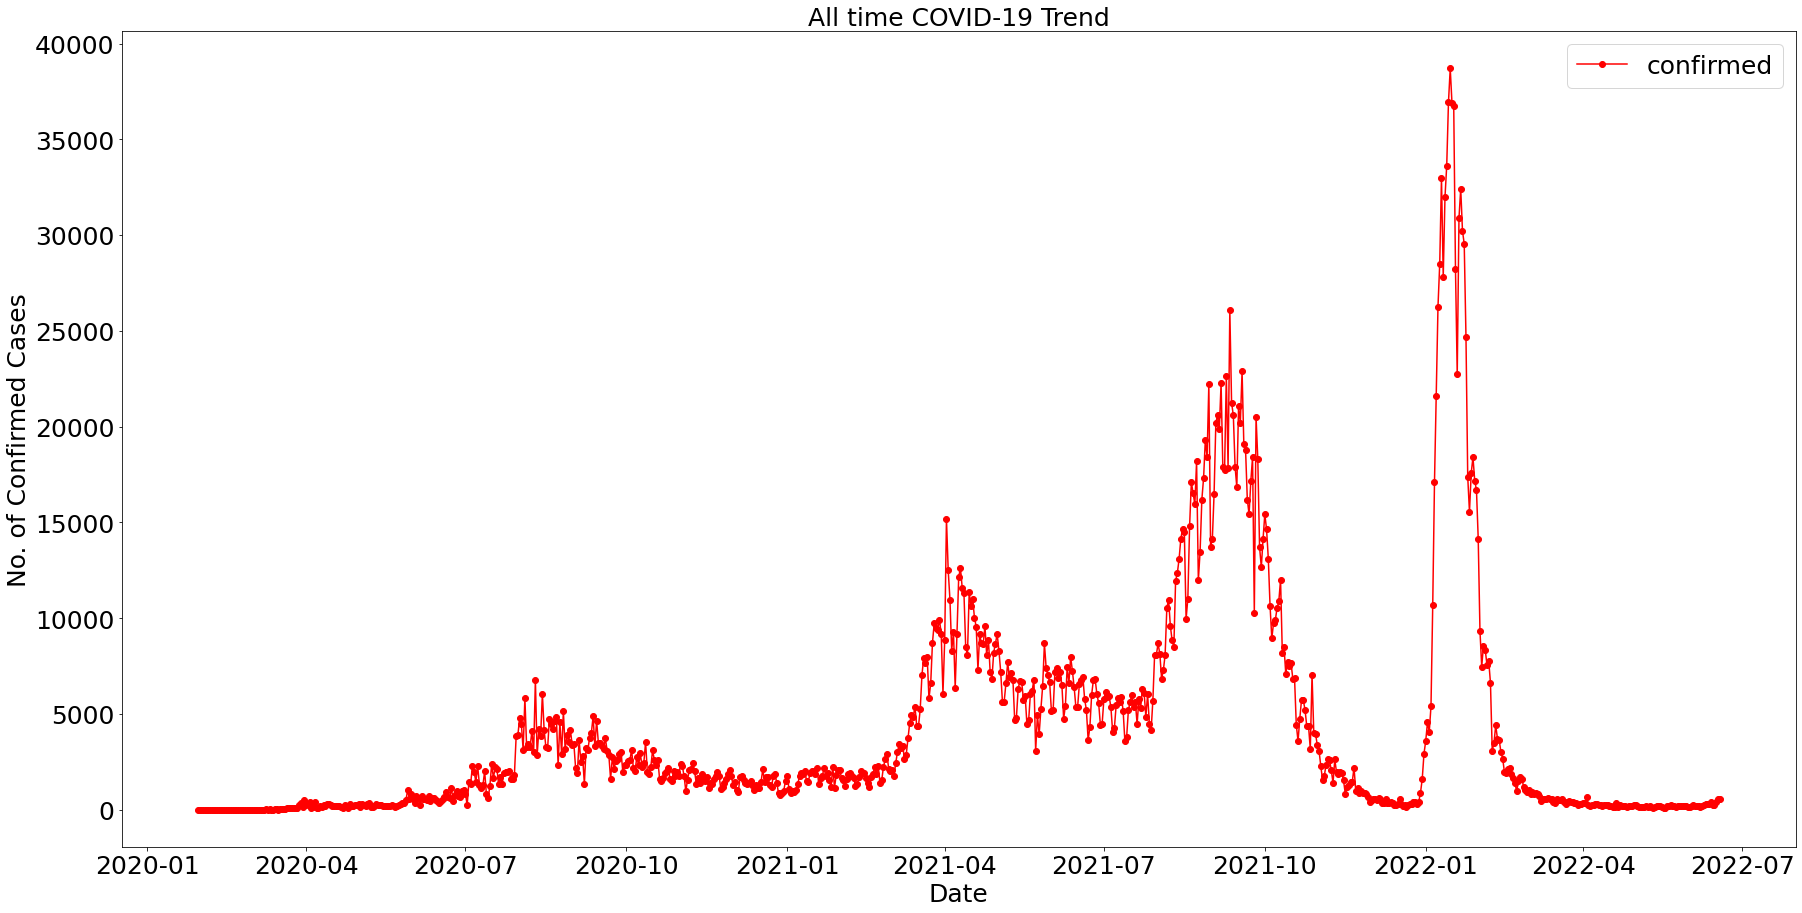

In [103]:
plt.figure(figsize = (30, 15))

# imputed data (red)
plt.plot(imputed_case_tsa['date'], imputed_case_tsa['confirmed'], color = 'red', label = 'confirmed', marker = 'o')

# # original data (orange)
# plt.plot(case_tsa_data['date'], case_tsa_data['confirmed'], color = 'orange', label = 'original')

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('All time COVID-19 Trend', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Confirmed Cases', fontsize = 25);

### Moving Averages and Weekly Aggregation

As shown on the graph above, plotting the data on a daily basis proves to be too "erratic" in terms of how it is represented, such that certain spikes in the number of cases created an abrupt turn on the graph. Aggregating the imputed data on a moving average and weekly basis would provide smoother graphs for the trend of confirmed cases.

In [104]:
imputed_case_tsa.columns

Index(['confirmed', 'asymptomatic', 'critical', 'mild', 'moderate', 'severe',
       'date'],
      dtype='object')

In [105]:
# Weekly aggregation

weekly_conf_agg = imputed_case_tsa.groupby(pd.Grouper(key = 'date', freq = 'W'))['confirmed',
                                                                                 'asymptomatic',
                                                                                 'critical',
                                                                                 'mild',
                                                                                 'moderate',
                                                                                 'severe'].mean().reset_index()
weekly_conf_agg['confirmed'] = weekly_conf_agg['confirmed'].astype(int)
weekly_conf_agg.head(10)

C:\Users\adria\AppData\Local\Temp\ipykernel_22448\3572869905.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  weekly_conf_agg = imputed_case_tsa.groupby(pd.Grouper(key = 'date', freq = 'W'))['confirmed',


,date,confirmed,asymptomatic,critical,mild,moderate,severe
0,2020-02-02,0,0.0,0.0,0.0,0.0,0.0
1,2020-02-09,0,0.0,0.0,0.0,0.0,0.0
2,2020-02-16,0,0.0,0.0,0.0,0.0,0.0
3,2020-02-23,0,0.0,0.0,0.0,0.0,0.0
4,2020-03-01,0,0.0,0.0,0.0,0.0,0.0
5,2020-03-08,1,0.0,0.0,0.0,0.0,0.0
6,2020-03-15,18,0.0,0.0,0.0,0.0,0.0
7,2020-03-22,34,0.0,0.0,0.0,0.0,0.0
8,2020-03-29,147,0.0,0.0,0.0,0.0,0.0
9,2020-04-05,259,0.0,0.0,0.0,0.0,0.0


In [106]:
# 7 Day MA aggregation
imputed_case_tsa['7DayMA'] = imputed_case_tsa['confirmed'].rolling(window = 7).mean()
imputed_case_tsa.head(10)

,confirmed,asymptomatic,critical,mild,moderate,severe,date,7DayMA
2020-01-30,1,0.0,0.0,0.0,0.0,0.0,2020-01-30,NaN
2020-01-31,0,0.0,0.0,0.0,0.0,0.0,2020-01-31,NaN
2020-02-01,0,0.0,0.0,0.0,0.0,0.0,2020-02-01,NaN
2020-02-02,0,0.0,0.0,0.0,0.0,0.0,2020-02-02,NaN
2020-02-03,1,0.0,0.0,0.0,0.0,0.0,2020-02-03,NaN
2020-02-04,0,0.0,0.0,0.0,0.0,0.0,2020-02-04,NaN
2020-02-05,1,0.0,0.0,0.0,0.0,0.0,2020-02-05,0.428571
2020-02-06,0,0.0,0.0,0.0,0.0,0.0,2020-02-06,0.285714
2020-02-07,0,0.0,0.0,0.0,0.0,0.0,2020-02-07,0.285714
2020-02-08,0,0.0,0.0,0.0,0.0,0.0,2020-02-08,0.285714


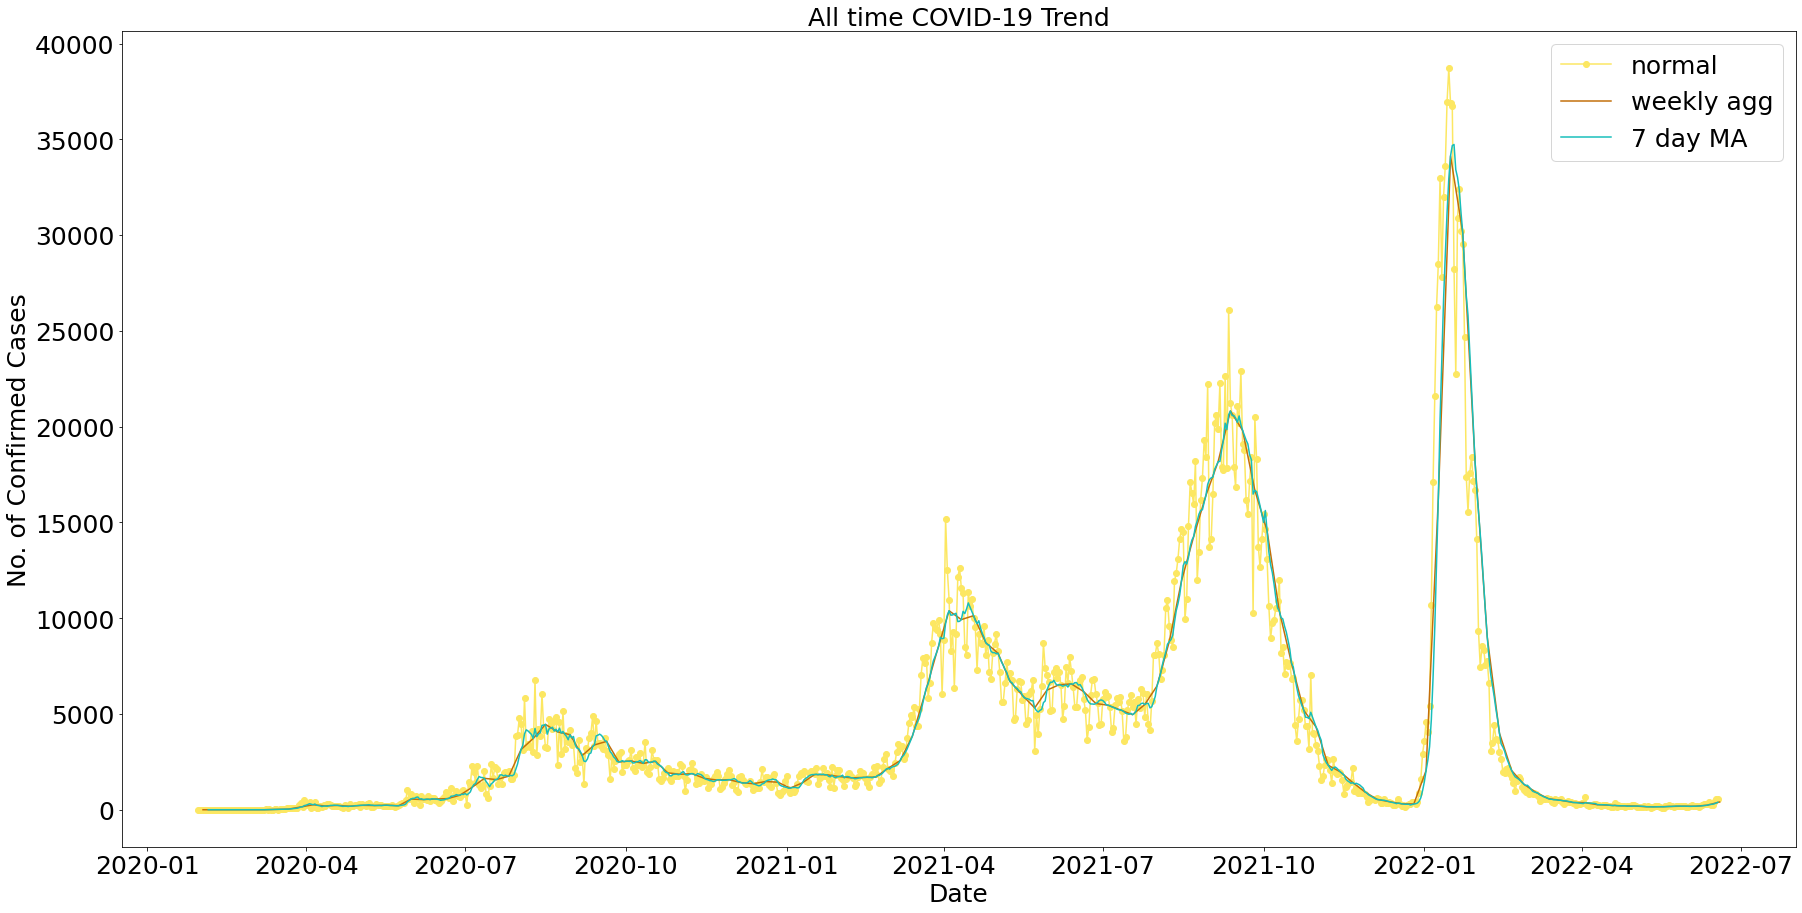

In [107]:
plt.figure(figsize = (30, 15))

# plotting the imputed data
plt.plot(imputed_case_tsa['date'], imputed_case_tsa['confirmed'], color = '#FCE762', label = 'normal', marker = 'o')

# plotting the weekly aggregated
plt.plot(weekly_conf_agg['date'], weekly_conf_agg['confirmed'], color = '#C36F09', label = 'weekly agg')

# plotting the 7 day moving average
plt.plot(imputed_case_tsa['date'], imputed_case_tsa['7DayMA'], color = '#17BEBB', label = '7 day MA')

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('All time COVID-19 Trend', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Confirmed Cases', fontsize = 25);

In [108]:
test = imputed_case_tsa.tail(30)
test.head()

,confirmed,asymptomatic,critical,mild,moderate,severe,date,7DayMA
2022-05-20,211,0.0,1.0,0.0,7.0,3.0,2022-05-20,163.571429
2022-05-21,244,0.0,0.0,0.0,6.0,2.0,2022-05-21,174.000000
2022-05-22,189,0.0,0.0,0.0,6.0,3.0,2022-05-22,172.000000
2022-05-23,189,0.0,0.0,0.0,3.0,1.0,2022-05-23,176.428571
2022-05-24,147,0.0,0.0,0.0,6.0,1.0,2022-05-24,181.857143


## NCR COVID-19 Time Series Analysis

Using the previously identified methods in wrangling and preparing the data for time series analysis, a similar analyis can also be performed as well for cases within NCR.

In [109]:
ncr_city_cases.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus,CaseCode_n
0,C178743,39.0,35 to 39,MALE,2020-03-06,2020-03-08,2020-03-08,NaT,2020-03-21,RECOVERED,...,CITY OF MAKATI,PH137602000,NaN,NaN,RECOVERED,YES,2020-03-03,NaN,Age or Birthdate is Invalid,1
1,C557002,86.0,80+,MALE,2020-03-06,2020-03-08,2020-03-08,2020-03-14,NaT,DIED,...,CITY OF MARIKINA,PH137402000,NaN,NaN,DIED,NO,2020-03-01,NaN,Age or Birthdate is Invalid,1
2,C261719,57.0,55 to 59,MALE,2020-03-07,2020-03-09,2020-03-09,2020-03-15,NaT,DIED,...,CITY OF MANILA,PH133906000,NaN,NaN,DIED,NO,NaT,NaN,NaN,1
3,C985840,51.0,50 to 54,FEMALE,2020-03-07,2020-03-09,2020-03-09,NaT,NaT,RECOVERED,...,CITY OF SAN JUAN,PH137405000,NaN,NaN,RECOVERED,NO,2020-03-04,NO,"Age or Birthdate is Invalid\nRemoval Type is ""...",1
4,C557823,41.0,40 to 44,MALE,NaT,NaT,2020-03-09,NaT,2020-03-24,RECOVERED,...,CITY OF PASIG,PH137403000,NaN,NaN,RECOVERED,NO,NaT,NaN,Age or Birthdate is Invalid,1


In [110]:
ncr_case_status = ncr_city_cases[['CaseCode', 'CaseCode_n', 'DateRepConf', 'DateDied', 'DateRecover', 'HealthStatus']]
ncr_case_status['status_encoded'] = le_healthstatus.fit_transform(ncr_case_status['HealthStatus'])
ncr_case_status.head()

C:\Users\adria\AppData\Local\Temp\ipykernel_22448\3470047323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncr_case_status['status_encoded'] = le_healthstatus.fit_transform(ncr_case_status['HealthStatus'])


,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,HealthStatus,status_encoded
0,C178743,1,2020-03-08,NaT,2020-03-21,RECOVERED,5
1,C557002,1,2020-03-08,2020-03-14,NaT,DIED,2
2,C261719,1,2020-03-09,2020-03-15,NaT,DIED,2
3,C985840,1,2020-03-09,NaT,NaT,RECOVERED,5
4,C557823,1,2020-03-09,NaT,2020-03-24,RECOVERED,5


In [111]:
ncr_case_status[['HealthStatus', 'status_encoded']].drop_duplicates()

,HealthStatus,status_encoded
0,RECOVERED,5
1,DIED,2
864206,MILD,3
864472,CRITICAL,1
865644,MODERATE,4
866418,ASYMPTOMATIC,0
872449,SEVERE,6


In [112]:
ncr_status_ohe = OneHotEncoder()
X_ncr_status = status_ohe.fit_transform(ncr_case_status['HealthStatus'].values.reshape(-1,1)).toarray()
print(X_ncr_status)
print(X_ncr_status.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1171893, 7)


In [113]:
ncr_status_OH = pd.DataFrame(X_ncr_status, columns = ["status" + str(int(i)) for i in range(X_ncr_status.shape[1])])
ncr_status_OH.head()

,status0,status1,status2,status3,status4,status5,status6
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [114]:
ncr_status_OH = ncr_status_OH.reset_index(drop = True)
ncr_case_status = ncr_case_status.reset_index(drop = True)

In [115]:
ncr_case_status.shape

(1171893, 7)

In [116]:
ncr_case_test = pd.concat([ncr_case_status, ncr_status_OH], axis = 1)
ncr_case_test.head()

,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,HealthStatus,status_encoded,status0,status1,status2,status3,status4,status5,status6
0,C178743,1,2020-03-08,NaT,2020-03-21,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,C557002,1,2020-03-08,2020-03-14,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,C261719,1,2020-03-09,2020-03-15,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,C985840,1,2020-03-09,NaT,NaT,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,C557823,1,2020-03-09,NaT,2020-03-24,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [117]:
case_ncr_tsa = ncr_case_test.groupby(['DateRepConf'], as_index = False)['CaseCode_n', 'status0', 'status1',
       'status3', 'status4', 'status6'].sum()

#rename columns
case_ncr_tsa = case_ncr_tsa.rename(columns = {'DateRepConf' : 'date',
                                              'CaseCode_n' : 'confirmed',
                                              'status0' : 'asymptomatic',
                                              'status1' : 'critical',
                                              'status3' : 'mild',
                                              'status4' : 'moderate',
                                              'status6' : 'severe'})
case_ncr_tsa.head()

C:\Users\adria\AppData\Local\Temp\ipykernel_22448\1363930423.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  case_ncr_tsa = ncr_case_test.groupby(['DateRepConf'], as_index = False)['CaseCode_n', 'status0', 'status1',


,date,confirmed,asymptomatic,critical,mild,moderate,severe
0,2020-03-08,2,0.0,0.0,0.0,0.0,0.0
1,2020-03-09,11,0.0,0.0,0.0,0.0,0.0
2,2020-03-10,7,0.0,0.0,0.0,0.0,0.0
3,2020-03-11,13,0.0,0.0,0.0,0.0,0.0
4,2020-03-12,2,0.0,0.0,0.0,0.0,0.0


In [118]:
df_ncr_recoveries_test = ncr_case_test.loc[ncr_case_test['DateRecover'] > ncr_case_test['DateRepConf']]
df_ncr_recoveries_test.head(10)

,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,HealthStatus,status_encoded,status0,status1,status2,status3,status4,status5,status6
0,C178743,1,2020-03-08,NaT,2020-03-21,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,C557823,1,2020-03-09,NaT,2020-03-24,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,C817111,1,2020-03-09,NaT,2020-03-26,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,C777589,1,2020-03-09,NaT,2020-03-24,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,C941779,1,2020-03-09,NaT,2020-03-15,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,C348794,1,2020-03-09,NaT,2020-03-19,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10,C261144,1,2020-03-09,NaT,2020-03-19,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,C787672,1,2020-03-09,NaT,2020-03-27,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12,C502781,1,2020-03-09,NaT,2020-03-15,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14,C767909,1,2020-03-10,NaT,2020-03-22,RECOVERED,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [119]:
recover_ncr_tsa = df_ncr_recoveries_test.groupby(['DateRecover'], as_index = False)['status5'].sum()

#rename columns
recover_ncr_tsa = recover_ncr_tsa.rename(columns = {'DateRecover' : 'date',
                                                   'status5' : 'recovered'})
recover_ncr_tsa.head(10)

,date,recovered
0,2020-03-15,2.0
1,2020-03-17,5.0
2,2020-03-18,2.0
3,2020-03-19,3.0
4,2020-03-20,2.0
5,2020-03-21,2.0
6,2020-03-22,4.0
7,2020-03-23,4.0
8,2020-03-24,7.0
9,2020-03-25,2.0


In [120]:
df_ncr_deaths_test = ncr_case_test.loc[ncr_case_test['DateDied'] > ncr_case_test['DateRepConf']]
df_ncr_deaths_test.head()

,CaseCode,CaseCode_n,DateRepConf,DateDied,DateRecover,HealthStatus,status_encoded,status0,status1,status2,status3,status4,status5,status6
1,C557002,1,2020-03-08,2020-03-14,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,C261719,1,2020-03-09,2020-03-15,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,C382946,1,2020-03-09,2020-04-09,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13,C766724,1,2020-03-10,2020-03-23,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29,C854599,1,2020-03-11,2020-03-13,NaT,DIED,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [121]:
died_ncr_tsa = df_ncr_deaths_test.groupby(['DateDied'], as_index = False)['status2'].sum()

#rename columns
died_ncr_tsa = died_ncr_tsa.rename(columns = {'DateDied' : 'date', 'status2' : 'died'})
died_ncr_tsa.head(10)

,date,died
0,2020-03-13,1.0
1,2020-03-14,1.0
2,2020-03-15,2.0
3,2020-03-17,3.0
4,2020-03-19,1.0
5,2020-03-21,1.0
6,2020-03-22,2.0
7,2020-03-23,5.0
8,2020-03-24,2.0
9,2020-03-25,1.0


### NCR Time Series Data Imputation
Using the previously identified function which fills out empty dates, the identified DataFrames pertaining to the number of recovered, died, and reported cases can be imputed.

In [122]:
imputed_case_ncr = case_ncr_tsa.copy()
imputed_case_ncr.index = imputed_case_ncr['date']
imputed_case_ncr = fill_in_missing_dates(imputed_case_ncr,
                                         date_col_name = 'date',
                                         fill_val = 0,
                                         date_format = '%Y-%m-%d')

imputed_case_ncr['date'] = imputed_case_ncr.index
imputed_case_ncr['7DayMA'] = imputed_case_ncr['confirmed'].rolling(window = 7).mean()

missing_dates are DatetimeIndex([], dtype='datetime64[ns]', freq='D')


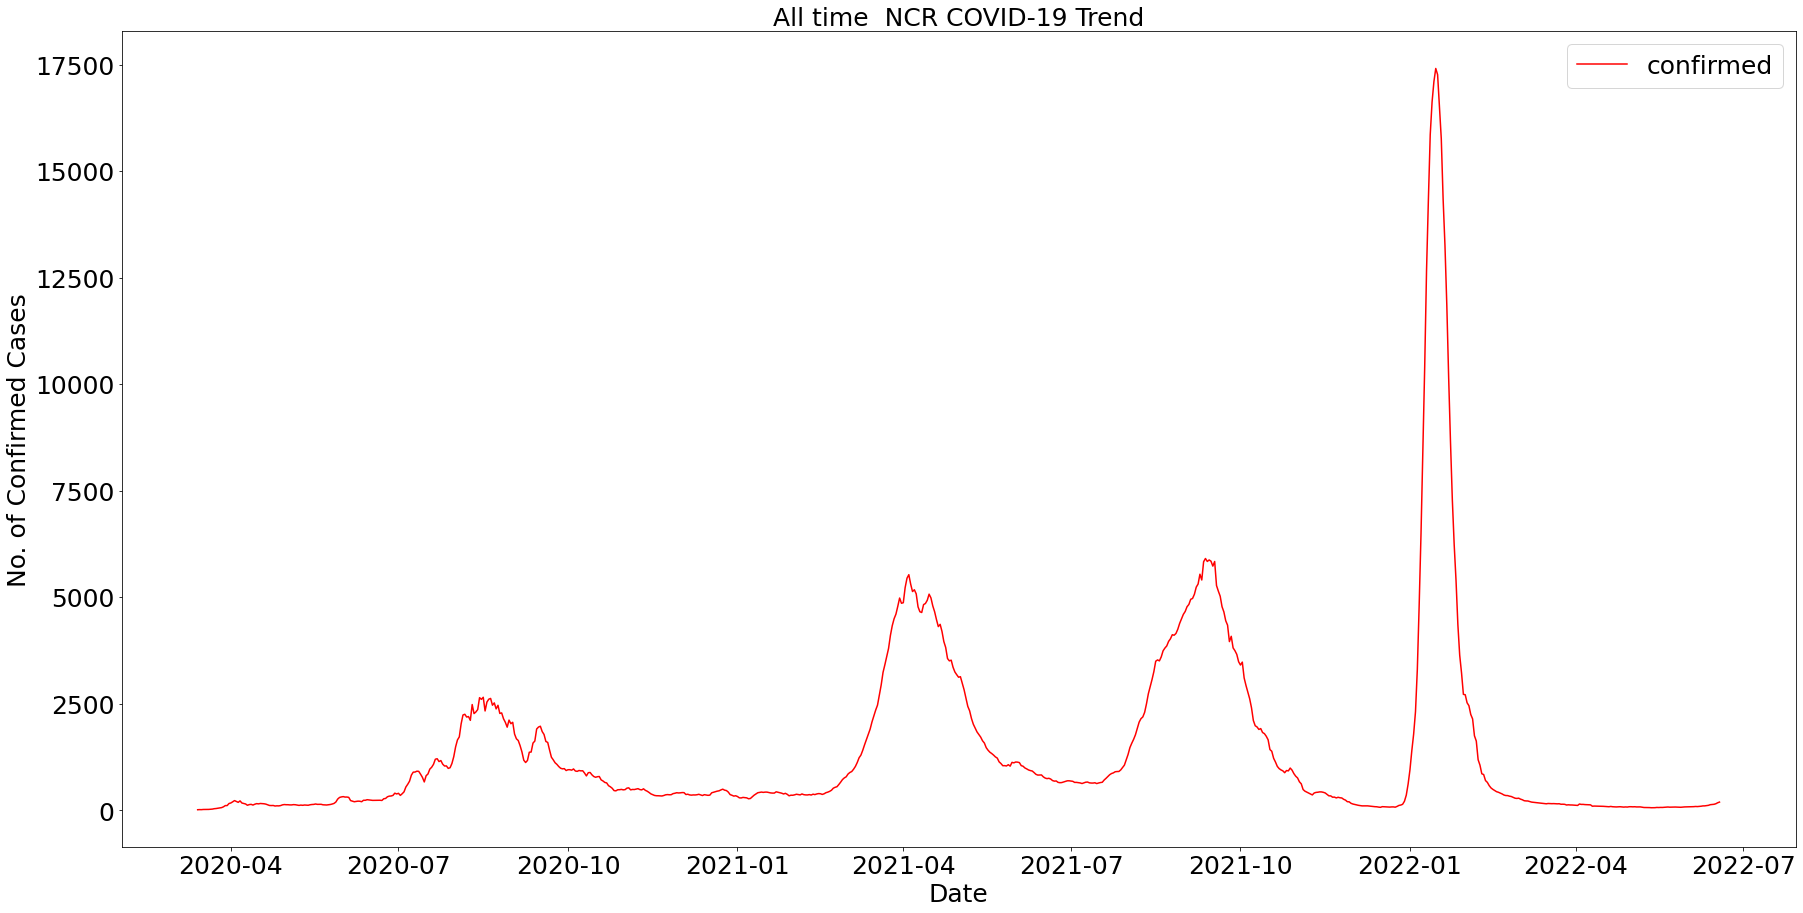

In [123]:
plt.figure(figsize = (30, 15))

plt.plot(imputed_case_ncr['date'], imputed_case_ncr['7DayMA'],
         color = 'red',
         label = 'confirmed')

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('All time  NCR COVID-19 Trend', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Confirmed Cases', fontsize = 25);

### Recovered

In [124]:
imputed_recover_ncr = recover_ncr_tsa.copy()
imputed_recover_ncr.index = imputed_recover_ncr['date']
imputed_recover_ncr = fill_in_missing_dates(imputed_recover_ncr,
                                            date_col_name = 'date',
                                            fill_val = 0,
                                            date_format = '%Y-%m-%d')

imputed_recover_ncr['date'] = imputed_recover_ncr.index
imputed_recover_ncr['7DayMA'] = imputed_recover_ncr['recovered'].rolling(window = 7).mean()

missing_dates are DatetimeIndex(['2020-03-16', '2021-12-29', '2022-04-20'], dtype='datetime64[ns]', freq=None)


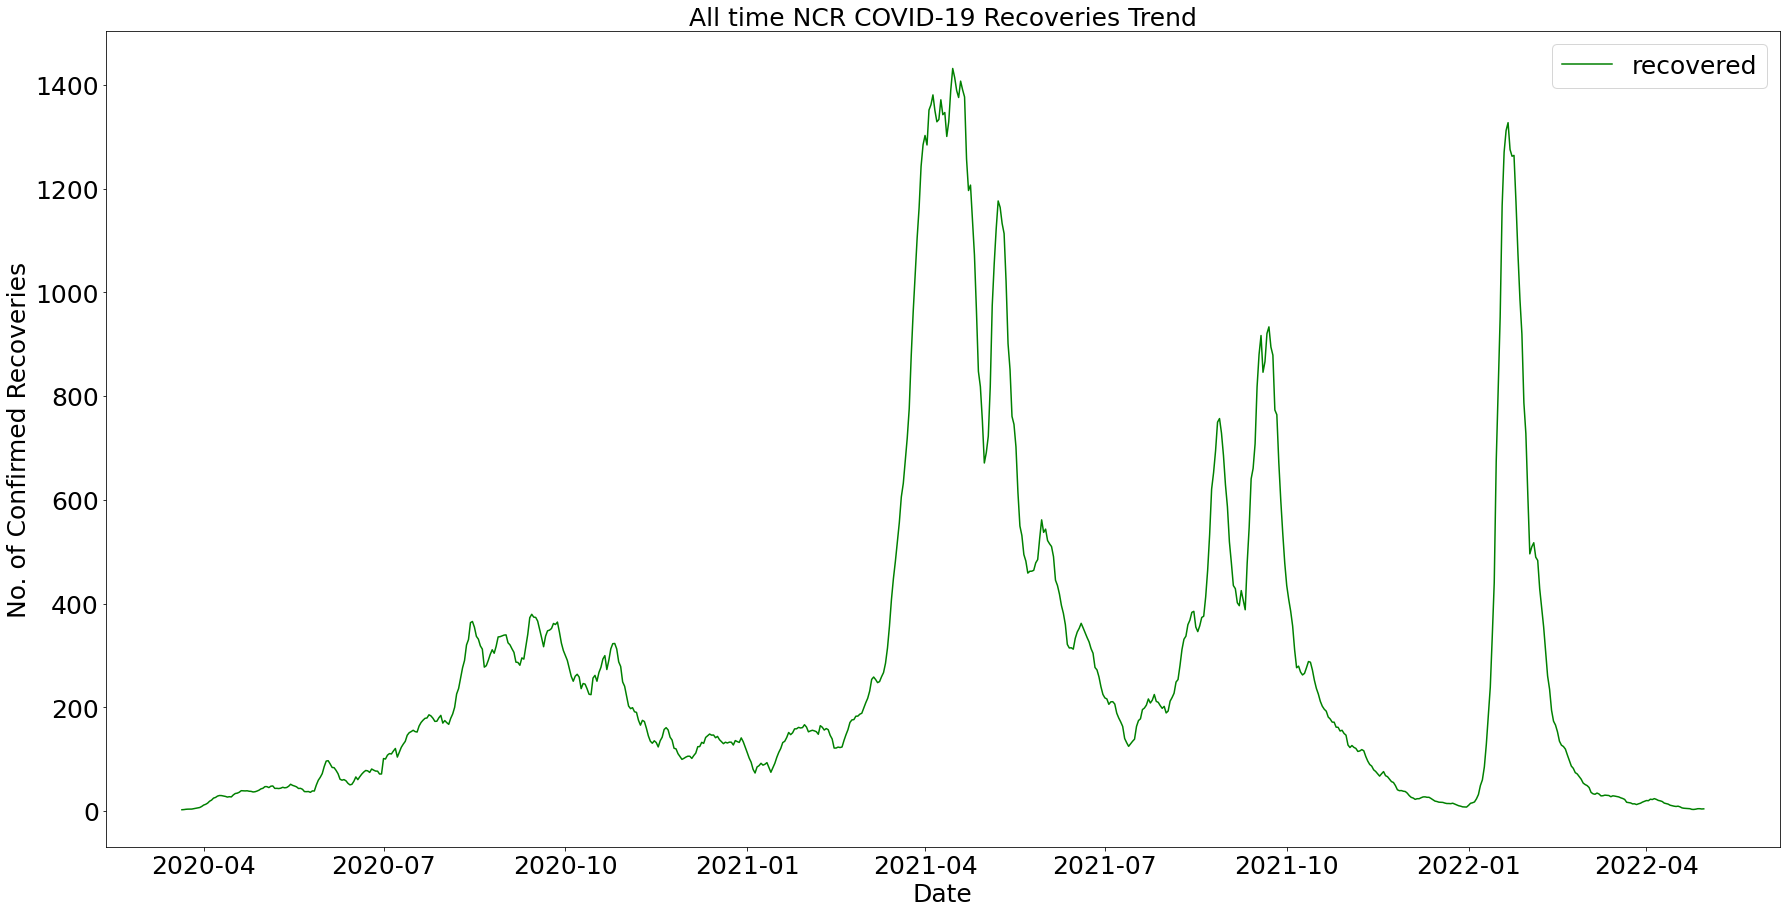

In [125]:
plt.figure(figsize = (30, 15))

plt.plot(imputed_recover_ncr['date'], imputed_recover_ncr['7DayMA'],
         color = 'green',
         label = 'recovered')

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('All time NCR COVID-19 Recoveries Trend', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Confirmed Recoveries', fontsize = 25);

### Died

In [126]:
imputed_deaths_ncr = died_ncr_tsa.copy()
imputed_deaths_ncr.index = imputed_deaths_ncr['date']
imputed_deaths_ncr = fill_in_missing_dates(imputed_deaths_ncr,
                                            date_col_name = 'date',
                                            fill_val = 0,
                                            date_format = '%Y-%m-%d')

imputed_deaths_ncr['date'] = imputed_deaths_ncr.index
imputed_deaths_ncr['7DayMA'] = imputed_deaths_ncr['died'].rolling(window = 7).mean()

missing_dates are DatetimeIndex(['2020-03-16', '2020-03-18', '2020-03-20', '2020-04-29',
               '2020-05-03', '2020-05-07', '2020-05-17', '2020-05-18',
               '2020-06-12', '2020-06-26', '2020-06-28', '2020-11-09',
               '2020-12-09', '2020-12-12', '2021-02-02', '2021-02-15',
               '2021-11-20', '2021-11-21', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-11', '2021-12-12', '2021-12-14',
               '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
               '2021-12-22', '2021-12-25', '2021-12-28', '2021-12-30',
               '2022-01-02', '2022-01-08', '2022-03-02', '2022-03-10',
               '2022-03-15', '2022-03-21', '2022-03-28', '2022-03-30',
               '2022-03-31', '2022-04-01', '2022-04-04', '2022-04-05',
               '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-13',
               '2022-04-17', '2022-04-20', '2022-04-24', '2022-04-26',
               '2022-04-27', '2022-04-29', '2022-05-01'],
 

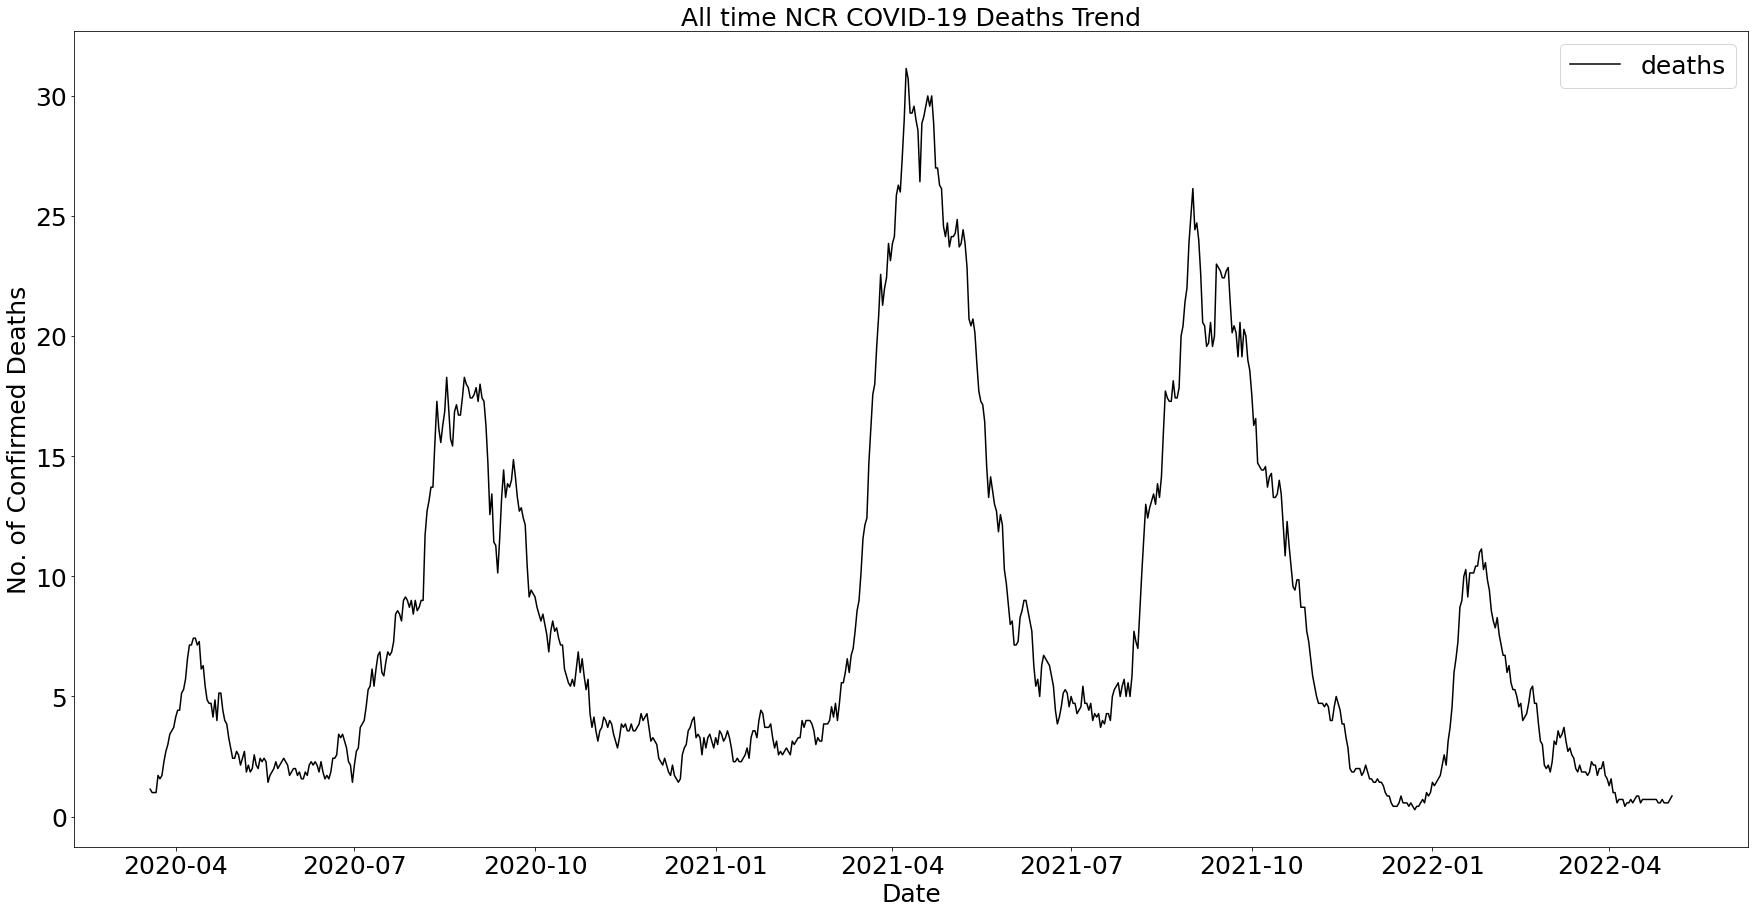

In [127]:
plt.figure(figsize = (30, 15))

plt.plot(imputed_deaths_ncr['date'], imputed_deaths_ncr['7DayMA'],
         color = 'black',
         label = 'deaths')

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('All time NCR COVID-19 Deaths Trend', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Confirmed Deaths', fontsize = 25);

In [128]:
ncr_monthly = imputed_case_ncr.tail(30)
ncr_monthly.head()

,confirmed,asymptomatic,critical,mild,moderate,severe,date,7DayMA
2022-05-20,89,0.0,0.0,0.0,3.0,0.0,2022-05-20,70.428571
2022-05-21,119,0.0,0.0,0.0,0.0,0.0,2022-05-21,75.428571
2022-05-22,54,0.0,0.0,0.0,1.0,1.0,2022-05-22,71.428571
2022-05-23,69,0.0,0.0,0.0,0.0,0.0,2022-05-23,72.571429
2022-05-24,55,0.0,0.0,0.0,0.0,0.0,2022-05-24,72.000000


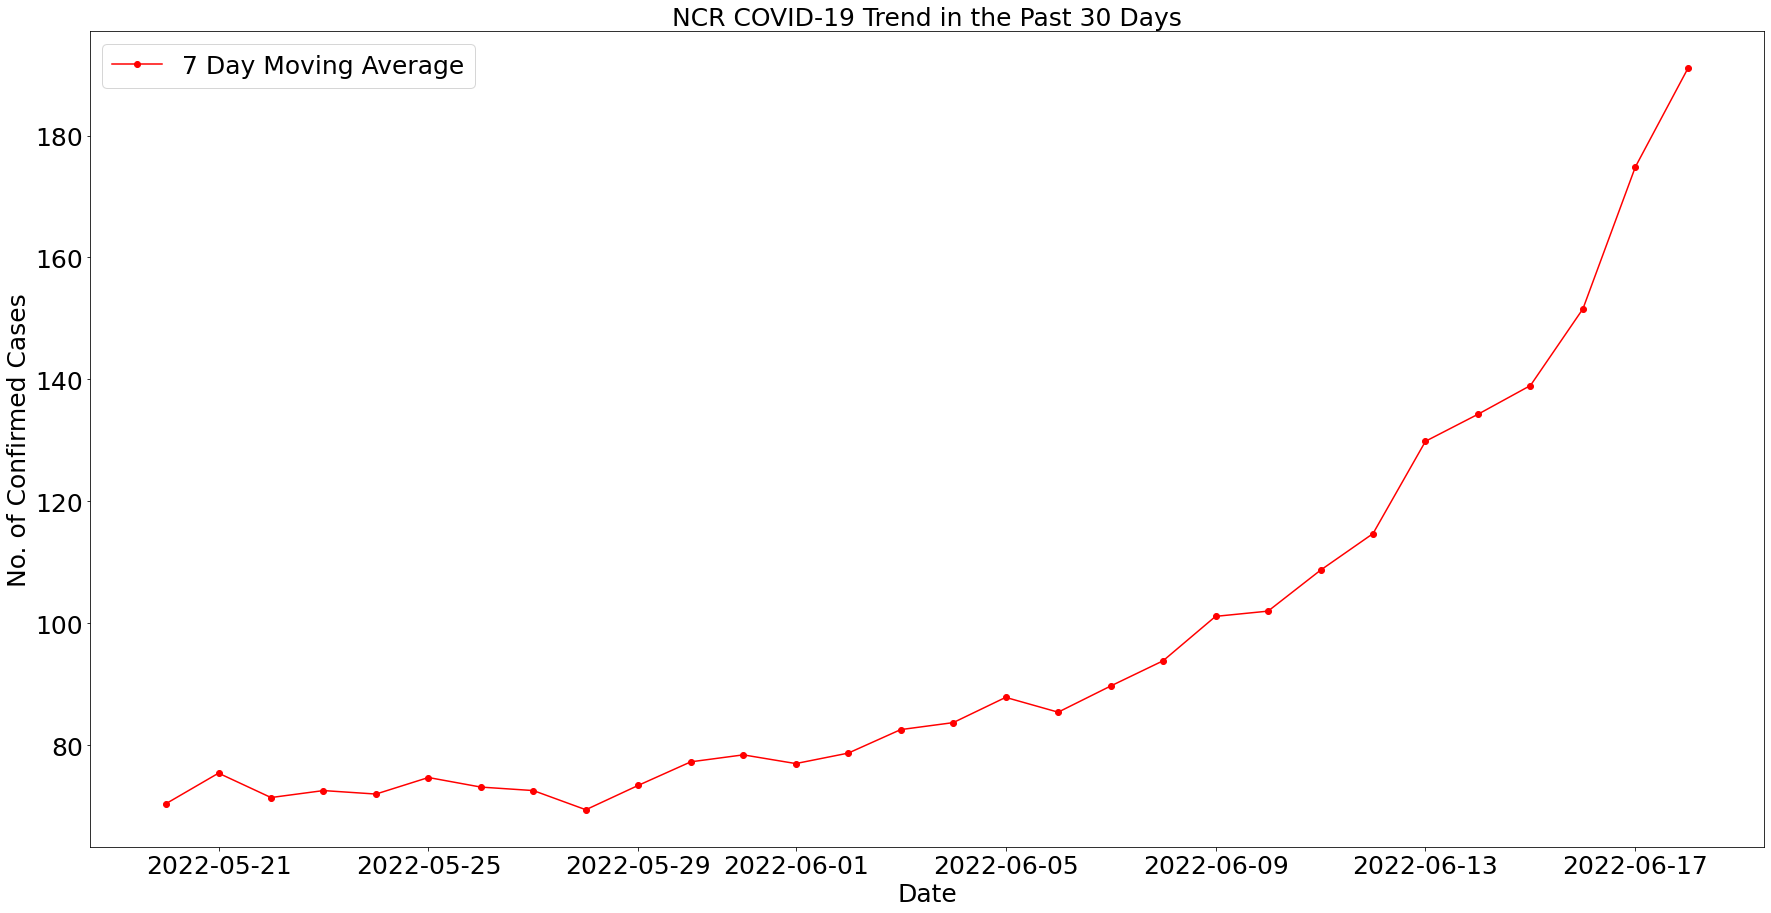

In [129]:
plt.figure(figsize = (30, 15))

plt.plot(ncr_monthly['date'], ncr_monthly['7DayMA'],
         color = 'red',
         label = '7 Day Moving Average',
         marker = 'o')

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('NCR COVID-19 Trend in the Past 30 Days', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Confirmed Cases', fontsize = 25);

## 7 Day Moving Averages of the Cities within NCR with the Highest Recorded Cases
The uptick in cases in the last 30 days among the Top 5 Cities within Metro Manila can also be examined as shown below. Using the presented graphic, which identifies how much COVID-19 is spreading in an area, we can create conclusions on how the virus is spreading in various areas as shown by the graphs below.

| How rapidly is COVID-19 spreading in the community? |	Number of positive COVID-19 cases per 100,000 per day |
|-------------- | ----------|
| Uncontrolled substantial spread |	5.1 or more cases |
| Controlled substantial spread | 2.6 to 5.0 cases |
| Moderate spread | 0.5 to 2.5 cases |
| Low spread | Less than 0.5 cases |

Source: https://www.nebraskamed.com/COVID/how-to-calculate-covid-19-stats-for-your-area

In [130]:
imputed_manila_case = daily_manila_case.copy()
imputed_manila_case.index = imputed_manila_case['date']

imputed_quezon_case = daily_quezon_case.copy()
imputed_quezon_case.index = imputed_quezon_case['date']

imputed_pasig_case = daily_pasig_case.copy()
imputed_pasig_case.index = imputed_pasig_case['date']

imputed_taguig_case = daily_taguig_case.copy()
imputed_taguig_case.index = imputed_taguig_case['date']

imputed_caloocan_case = daily_caloocan_case.copy()
imputed_caloocan_case.index = imputed_caloocan_case['date']

cities_ncr = [imputed_manila_case, imputed_quezon_case, imputed_pasig_case, imputed_taguig_case, imputed_caloocan_case]

In [131]:
imputed_cities_ncr = []
for x in cities_ncr:
    x = fill_in_missing_dates(x,
                              date_col_name = 'date',
                              fill_val = 0,
                              date_format = '%Y-%m-%d')
    x = x.drop(columns = ['city'])
    x['date'] = x.index
    x['7DayMA'] = x['count'].rolling(window = 7).mean()
    imputed_cities_ncr.append(x)

missing_dates are DatetimeIndex(['2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-16', '2020-03-18'],
              dtype='datetime64[ns]', freq=None)
missing_dates are DatetimeIndex(['2020-03-10', '2020-03-16'], dtype='datetime64[ns]', freq=None)
missing_dates are DatetimeIndex(['2020-03-10', '2020-03-12', '2020-03-16', '2020-05-02',
               '2020-05-14', '2020-05-22', '2020-06-17', '2020-07-02',
               '2022-03-14', '2022-04-19', '2022-05-10', '2022-05-18'],
              dtype='datetime64[ns]', freq=None)
missing_dates are DatetimeIndex(['2020-03-15', '2020-03-16', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-23', '2020-04-17', '2020-04-22',
               '2020-05-07', '2020-05-08', '2020-05-10', '2020-05-20',
               '2020-06-05', '2021-12-14', '2021-12-15', '2022-04-21'],
              dtype='datetime64[ns]', freq=None)
missing_dates are DatetimeIndex(['2020-03-12', '2020-03-13', '2020-03-16', '2020-03-18',

In [132]:
# imputed_cities_ncr[0].head(10)
top_5_ncr = ['manila', 'quezon', 'pasig', 'taguig', 'caloocan']
population = [1.78e6, 2.9e6, 6.17e5, 6.44e5, 1.5e6]
past_month_cases = []
for cities in imputed_cities_ncr:
    cities = cities.tail(30)
    past_month_cases.append(cities)

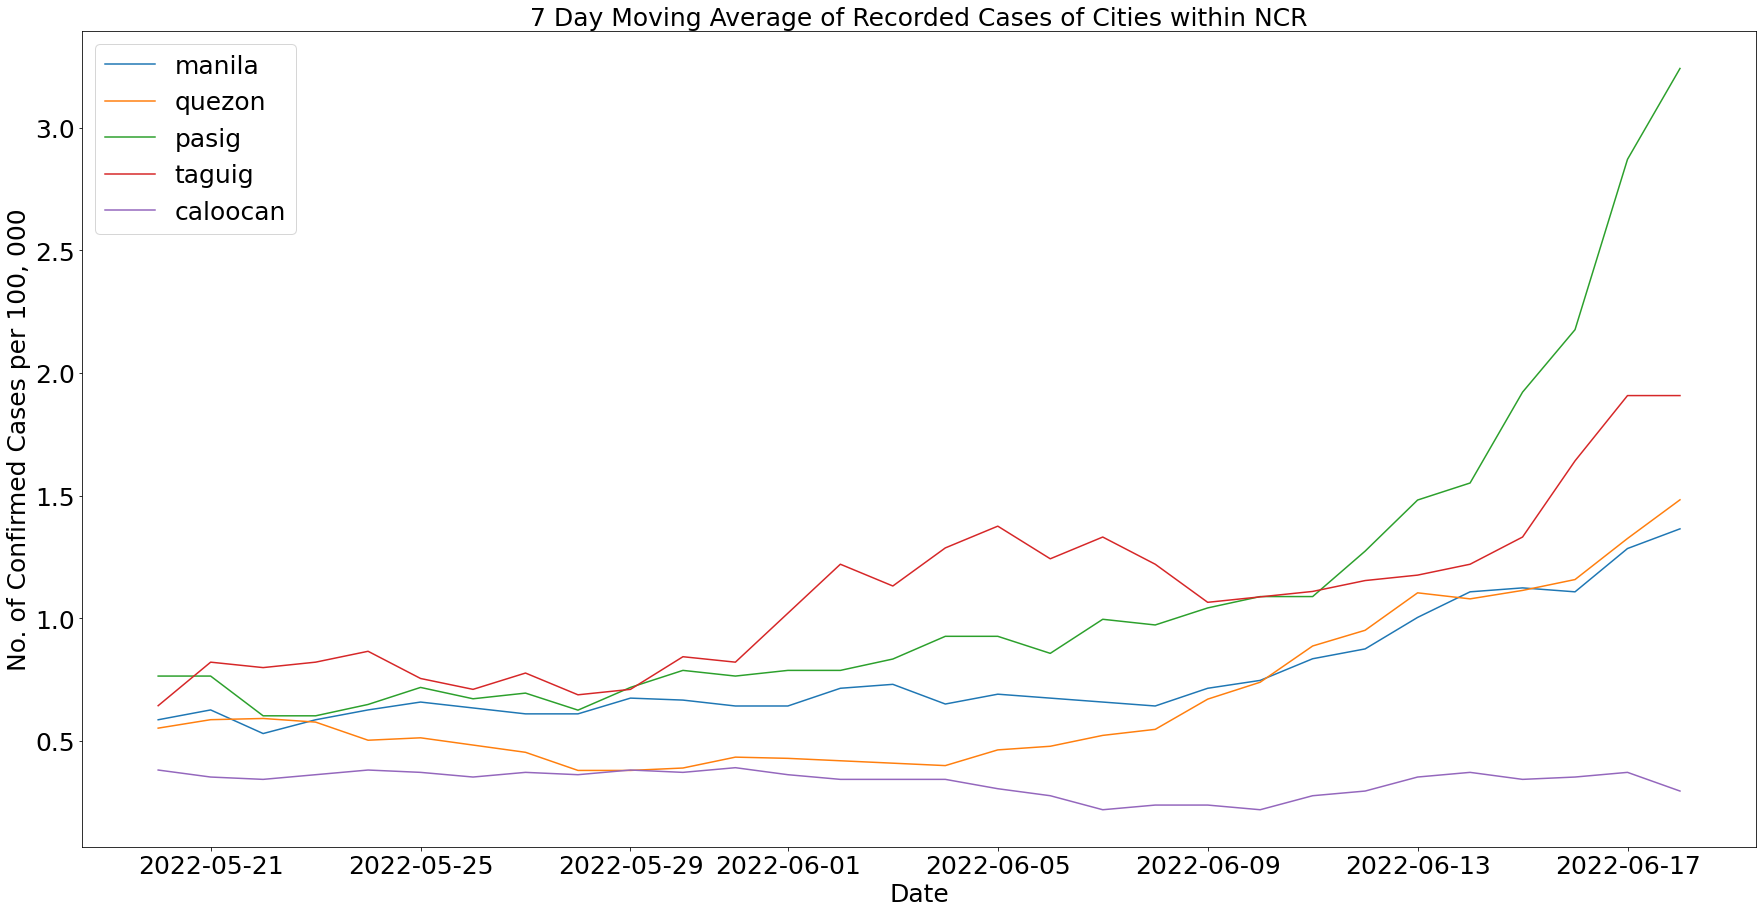

In [133]:
plt.figure(figsize = (30, 15))

for cities, name, pop in zip(past_month_cases, top_5_ncr, population):
    plt.plot(cities['date'], ((cities['7DayMA']/pop)*1e5),
             label = name)

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('7 Day Moving Average of Recorded Cases of Cities within NCR', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Confirmed Cases per 100, 000', fontsize = 25);

## 7 Day Moving Averages of the Regions with the Highest Recorded Cases
The uptick in cases in the last 30 days among the Top 5 Regions can also be examined as shown below

In [134]:
ncr_daily_cases.head()

,date,region,count
0,2020-03-08,NCR,2
1,2020-03-09,NCR,11
2,2020-03-10,NCR,7
3,2020-03-11,NCR,13
4,2020-03-12,NCR,2


In [135]:
imputed_regional = []
regional_daily = [r4a_daily_cases, r3_daily_cases, r6_daily_cases, r7_daily_cases, ncr_daily_cases]

for x in regional_daily:
    x.index = x['date']
    
    x = fill_in_missing_dates(x,
                              date_col_name = 'date',
                              fill_val = 0,
                              date_format = '%Y-%m-%d')
    x = x.drop(columns = ['region'])
    x['date'] = x.index
    x['7DayMA'] = x['count'].rolling(window = 7).mean()
    imputed_regional.append(x)

missing_dates are DatetimeIndex(['2020-03-08', '2020-03-10', '2020-03-16', '2020-03-20'], dtype='datetime64[ns]', freq=None)
missing_dates are DatetimeIndex(['2020-03-11', '2020-03-12', '2020-03-16', '2020-03-18',
               '2020-03-19', '2020-03-20', '2020-04-25', '2020-05-02',
               '2020-05-08'],
              dtype='datetime64[ns]', freq=None)
missing_dates are DatetimeIndex(['2020-03-22', '2020-03-23', '2020-03-24', '2020-03-26',
               '2020-03-30', '2020-04-01', '2020-04-05', '2020-04-06',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-11',
               '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-21',
               '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-29',
               '2020-05-02', '2020-05-05', '2020-05-07', '2020-05-08',
               '2020-05-10', '2020-05-11', '2020-05-13', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-21',
               '2020-05-22', '2020-05-24', '2020-0

In [136]:
# # imputed_cities_ncr[0].head(10)
# top_5_ncr = ['manila', 'quezon', 'pasig', 'taguig', 'caloocan']
# population = [1.78e6, 2.9e6, 6.17e5, 6.44e5, 1.5e6]
# past_month_cases = []
# for cities in imputed_cities_ncr:
#     cities = cities.tail(30)
#     past_month_cases.append(cities)

In [137]:
top_5_regions = ['ncr', 'region 4a', 'region 3', 'region 6', 'region 7']
regional_pop = [13e6, 16e6, 12e6, 7e6, 8e6]

past_month_regional_cases = []
for region in imputed_regional:
    region = region.tail(30)
    past_month_regional_cases.append(region)

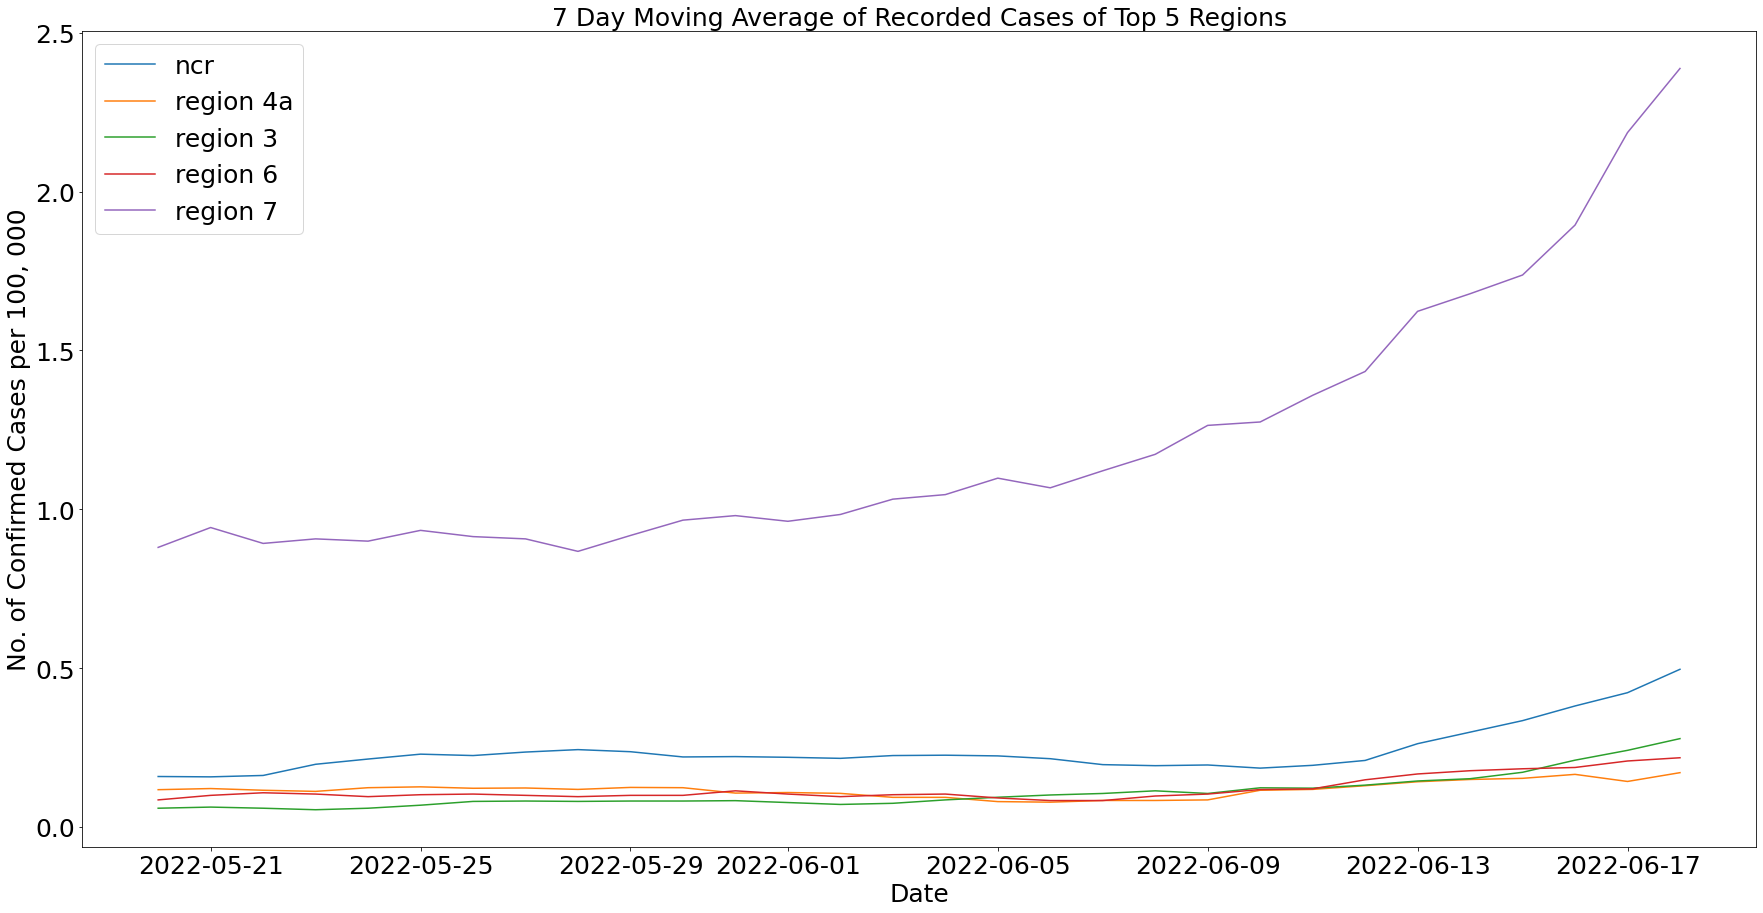

In [138]:
plt.figure(figsize = (30, 15))

for region, name, pop in zip(past_month_regional_cases, top_5_regions, regional_pop):
    plt.plot(region['date'], ((region['7DayMA']/pop)*1e5),
             label = name)

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('7 Day Moving Average of Recorded Cases of Top 5 Regions', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('No. of Confirmed Cases per 100, 000', fontsize = 25);

# Automation
This section of the notebook exclusively contains how the time series datasets are prepared for publishing. 

## Regions

### Confirmed

In [139]:
region_names = daily_regional_case['region'].unique()

In [140]:
region_names

array(['Region VII: Central Visayas', 'Region IV-A: CALABARZON', 'NCR',
       'ROF', 'Region III: Central Luzon', 'Region V: Bicol Region',
       'BARMM', 'Region I: Ilocos Region', 'Region II: Cagayan Valley',
       'Region IV-B: MIMAROPA', 'Region VI: Western Visayas',
       'Region XI: Davao Region', 'Region X: Northern Mindanao',
       'Region IX: Zamboanga Peninsula', 'Region XII: SOCCSKSARGEN',
       'CAR', 'CARAGA', 'Region VIII: Eastern Visayas'], dtype=object)

In [141]:
region_cases = []
for x in region_names:
    df_regional = daily_regional_case.loc[daily_regional_case['region'] == x]
    df_regional = df_regional.reset_index()
    df_regional = df_regional.drop(columns = ['index'])
    region_cases.append(df_regional)

In [142]:
imputed_regions_ph = []
for x in region_cases:
    x.index = x['date']
    
    x = fill_in_missing_dates(x,
                              date_col_name = 'date',
                              fill_val = 0,
                              date_format = '%Y-%m-%d')
    x['date'] = x.index
    x['7DayMA'] = x['count'].rolling(window = 7).mean()
    imputed_regions_ph.append(x)

missing_dates are DatetimeIndex(['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-04',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
               '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2

### Died

In [143]:
corrected_deaths = case_data.loc[case_data['DateDied'] > case_data['DateRepConf']]
corrected_deaths.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus,CaseCode_n
3,C498051,63.0,60 to 64,MALE,2020-03-05,NaT,2020-03-06,2020-03-11,NaT,DIED,...,CAINTA,PH045805000,NaN,NaN,DIED,NO,NaT,NaN,"Case has Lab Result, but Result Date is blank\...",1
5,C130591,58.0,55 to 59,FEMALE,2020-03-06,2020-03-07,2020-03-07,2020-03-12,NaT,DIED,...,CAINTA,PH045805000,NaN,NaN,DIED,NO,NaT,NO,Age or Birthdate is Invalid,1
8,C557002,86.0,80+,MALE,2020-03-06,2020-03-08,2020-03-08,2020-03-14,NaT,DIED,...,CITY OF MARIKINA,PH137402000,NaN,NaN,DIED,NO,2020-03-01,NaN,Age or Birthdate is Invalid,1
11,C261719,57.0,55 to 59,MALE,2020-03-07,2020-03-09,2020-03-09,2020-03-15,NaT,DIED,...,CITY OF MANILA,PH133906000,NaN,NaN,DIED,NO,NaT,NaN,NaN,1
15,C382946,52.0,50 to 54,MALE,2020-03-07,NaT,2020-03-09,2020-04-09,NaT,DIED,...,QUEZON CITY,PH137404000,NaN,NaN,DIED,NO,2020-03-03,NaN,"Case has Lab Result, but Result Date is blank\...",1


In [144]:
daily_regional_deaths = corrected_deaths.groupby(['DateDied', 'RegionRes'], as_index = False)['CaseCode_n'].sum()
daily_regional_deaths = daily_regional_deaths.rename(columns = {'DateDied' : 'date',
                                                                'RegionRes' : 'region',
                                                                'CaseCode_n' : 'count'})
daily_regional_deaths.head()

,date,region,count
0,2020-03-11,Region IV-A: CALABARZON,1
1,2020-03-12,Region IV-A: CALABARZON,1
2,2020-03-13,NCR,1
3,2020-03-14,NCR,1
4,2020-03-15,NCR,2


In [145]:
region_deaths = []
for x in region_names:
    df_regional = daily_regional_deaths.loc[daily_regional_deaths['region'] == x]
    df_regional = df_regional.reset_index()
    df_regional = df_regional.drop(columns = ['index'])
    region_deaths.append(df_regional)

In [146]:
imputed_regions_deaths = []
for x in region_deaths:
    x.index = x['date']
    
    x = fill_in_missing_dates(x,
                              date_col_name = 'date',
                              fill_val = 0,
                              date_format = '%Y-%m-%d')
    x['date'] = x.index
    x['7DayMA'] = x['count'].rolling(window = 7).mean()
    imputed_regions_deaths.append(x)

missing_dates are DatetimeIndex(['2020-04-04', '2020-04-06', '2020-04-07', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15',
               ...
               '2022-04-24', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29', '2022-04-30', '2022-05-01',
               '2022-05-02', '2022-05-03'],
              dtype='datetime64[ns]', length=208, freq=None)
missing_dates are DatetimeIndex(['2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
               '2020-03-22', '2020-03-24',
               ...
               '2022-04-25', '2022-04-27', '2022-04-28', '2022-04-29',
               '2022-04-30', '2022-05-02', '2022-05-03', '2022-05-04',
               '2022-05-05', '2022-05-06'],
              dtype='datetime64[ns]', length=173, freq=None)
missing_dates are DatetimeIndex(['2020-03-16', '2020-03-18', '

### Recoveries

In [147]:
corrected_recoveries = case_data.loc[case_data['DateRecover'] > case_data['DateRepConf']]
corrected_recoveries.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus,CaseCode_n
6,C440075,33.0,30 to 34,MALE,2020-03-06,2020-03-08,2020-03-08,NaT,2020-04-05,RECOVERED,...,NaN,NaN,NaN,NaN,RECOVERED,YES,2020-03-01,NaN,NaN,1
7,C178743,39.0,35 to 39,MALE,2020-03-06,2020-03-08,2020-03-08,NaT,2020-03-21,RECOVERED,...,CITY OF MAKATI,PH137602000,NaN,NaN,RECOVERED,YES,2020-03-03,NaN,Age or Birthdate is Invalid,1
9,C202135,57.0,55 to 59,MALE,2020-03-06,2020-03-08,2020-03-08,NaT,2020-03-23,RECOVERED,...,NaN,NaN,NaN,NaN,RECOVERED,NO,NaT,NaN,Age or Birthdate is Invalid,1
10,C861109,35.0,35 to 39,MALE,NaT,NaT,2020-03-09,NaT,2020-03-15,RECOVERED,...,NaN,NaN,NaN,NaN,RECOVERED,NO,NaT,NaN,NaN,1
13,C557823,41.0,40 to 44,MALE,NaT,NaT,2020-03-09,NaT,2020-03-24,RECOVERED,...,CITY OF PASIG,PH137403000,NaN,NaN,RECOVERED,NO,NaT,NaN,Age or Birthdate is Invalid,1


In [148]:
daily_regional_recoveries = corrected_recoveries.groupby(['DateRecover', 'RegionRes'], as_index = False)['CaseCode_n'].sum()
daily_regional_recoveries = daily_regional_recoveries.rename(columns = {'DateRecover' : 'date',
                                                                        'RegionRes' : 'region',
                                                                        'CaseCode_n' : 'count'})
daily_regional_recoveries.head()

,date,region,count
0,2020-03-13,Region IV-A: CALABARZON,1
1,2020-03-15,NCR,2
2,2020-03-15,ROF,1
3,2020-03-17,NCR,5
4,2020-03-17,Region III: Central Luzon,1


In [149]:
region_recoveries = []
for x in region_names:
    df_regional = daily_regional_recoveries.loc[daily_regional_recoveries['region'] == x]
    df_regional = df_regional.reset_index()
    df_regional = df_regional.drop(columns = ['index'])
    region_recoveries.append(df_regional)

In [150]:
imputed_regions_recover = []
for x in region_recoveries:
    x.index = x['date']
    
    x = fill_in_missing_dates(x,
                              date_col_name = 'date',
                              fill_val = 0,
                              date_format = '%Y-%m-%d')
    x['date'] = x.index
    x['7DayMA'] = x['count'].rolling(window = 7).mean()
    imputed_regions_recover.append(x)

missing_dates are DatetimeIndex(['2020-04-04', '2020-04-05', '2020-04-09', '2020-04-10',
               '2020-04-14', '2020-04-16', '2020-04-17', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-23', '2020-04-26',
               '2020-04-27', '2020-04-28', '2020-05-01', '2020-05-03',
               '2020-05-10', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-21', '2021-08-04', '2021-08-22',
               '2021-08-25', '2021-09-30', '2021-10-01', '2021-11-07',
               '2021-11-19', '2021-11-20', '2021-11-22', '2021-11-23',
               '2021-11-25', '2021-11-26', '2021-11-28', '2021-11-29',
               '2021-12-01', '2021-12-03', '2021-12-04', '2021-12-05',
               '2021-12-06', '2021-12-11', '2021-12-15', '2021-12-17',
               '2021-12-18', '2021-12-19', '2021-12-20', '2021-12-24',
               '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-29',
               '2021-12-30', '2021-12-31', '2022-01-01', '2

## Exporting all regions

In [151]:
for region, names in zip(imputed_regions_ph, region_names):
    region['region'] = region['region'].replace(to_replace = 0, value = names)
    names = names.replace(':', ' -') + ' TSA.csv'
    region.to_csv('complete_regions_confirmed/' + names, index = False)

for region, names in zip(imputed_regions_recover, region_names):
    region['region'] = region['region'].replace(to_replace = 0, value = names)
    names = names.replace(':', ' -') + ' TSA.csv'
    region.to_csv('complete_regions_recovered/' + names, index = False)

for region, names in zip(imputed_regions_deaths, region_names):
    region['region'] = region['region'].replace(to_replace = 0, value = names)
    names = names.replace(':', ' -') + ' TSA.csv'
    region.to_csv('complete_regions_died/' + names, index = False)

## Municipalities in NCR

### Confirmed Cases

In [152]:
daily_ncr_city_case.head()

,date,city,count
0,2020-03-08,CITY OF MAKATI,1
1,2020-03-08,CITY OF MARIKINA,1
2,2020-03-09,CITY OF MAKATI,1
3,2020-03-09,CITY OF MANILA,1
4,2020-03-09,CITY OF PASIG,2


In [153]:
city_names = daily_ncr_city_case['city'].unique()

In [154]:
ncr_city_cases = []
for x in city_names:
    df_city = daily_ncr_city_case.loc[daily_ncr_city_case['city'] == x]
    df_city = df_city.reset_index()
    df_city = df_city.drop(columns = ['index'])
    ncr_city_cases.append(df_city)

In [155]:
imputed_ncr_cities = []
for x in ncr_city_cases:
    x.index = x['date']
    
    x = fill_in_missing_dates(x,
                              date_col_name = 'date',
                              fill_val = 0,
                              date_format = '%Y-%m-%d')
    x['date'] = x.index
    x['7DayMA'] = x['count'].rolling(window = 7).mean()
    imputed_ncr_cities.append(x)

missing_dates are DatetimeIndex(['2020-03-12', '2020-03-15', '2020-03-18', '2020-03-20',
               '2020-05-07', '2020-05-18'],
              dtype='datetime64[ns]', freq=None)
missing_dates are DatetimeIndex(['2020-03-09', '2020-03-11', '2020-03-12', '2020-03-14',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-24', '2020-04-07', '2020-04-23', '2020-04-26',
               '2020-05-03', '2020-05-04', '2020-05-08', '2020-05-11',
               '2020-05-18', '2020-05-20', '2020-05-21', '2020-05-25',
               '2020-05-26', '2020-06-01', '2020-06-02', '2020-06-04',
               '2020-06-05', '2020-06-06', '2020-06-09', '2020-06-16',
               '2020-07-01', '2020-07-02', '2021-11-30', '2021-12-03',
               '2021-12-18', '2021-12-20', '2021-12-22', '2022-03-28',
               '2022-04-05', '2022-04-12', '2022-04-18', '2022-04-22',
               '2022-04-25', '2022-04-29', '2022-05-02', '2022-05-03',
               '202

### Died Cases

In [156]:
ncr_city = case_data.loc[case_data['RegionRes'] == 'NCR'].reset_index()
ncr_city = ncr_city.loc[ncr_city['DateDied'] > ncr_city['DateRepConf']]
ncr_city = ncr_city.drop(columns = ['index'])

daily_ncr_city_deaths = ncr_city.groupby(['DateDied', 'CityMunRes'], as_index = False)['CaseCode_n'].sum()
daily_ncr_city_deaths = daily_ncr_city_deaths.rename(columns = {'DateDied' : 'date',
                                                                'CityMunRes' : 'city',
                                                                'CaseCode_n' : 'count'})
daily_ncr_city_deaths.head()

,date,city,count
0,2020-03-13,CITY OF PASIG,1
1,2020-03-14,CITY OF MARIKINA,1
2,2020-03-15,CITY OF MANILA,1
3,2020-03-15,CITY OF PASIG,1
4,2020-03-17,CITY OF MARIKINA,1


In [157]:
ncr_city_deaths = []
for x in city_names:
    df_city = daily_ncr_city_deaths.loc[daily_ncr_city_deaths['city'] == x]
    df_city = df_city.reset_index()
    df_city = df_city.drop(columns = ['index'])
    ncr_city_deaths.append(df_city)

In [158]:
imputed_ncr_deaths = []
for x in ncr_city_deaths:
    x.index = x['date']
    
    x = fill_in_missing_dates(x,
                              date_col_name = 'date',
                              fill_val = 0,
                              date_format = '%Y-%m-%d')
    x['date'] = x.index
    x['7DayMA'] = x['count'].rolling(window = 7).mean()
    imputed_ncr_deaths.append(x)

missing_dates are DatetimeIndex(['2020-03-29', '2020-03-31', '2020-04-03', '2020-04-04',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-12',
               ...
               '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-12',
               '2022-03-13', '2022-03-14', '2022-03-15', '2022-03-16',
               '2022-03-17', '2022-03-18'],
              dtype='datetime64[ns]', length=492, freq=None)
missing_dates are DatetimeIndex(['2020-03-15', '2020-03-16', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-24',
               '2020-03-25', '2020-03-26',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11',
               '2022-04-12', '2022-04-13'],
              dtype='datetime64[ns]', length=533, freq=None)
missing_dates are DatetimeIndex(['2020-03-16', '2020-03-17', '

### Recovered Cases

In [159]:
ncr_city = case_data.loc[case_data['RegionRes'] == 'NCR'].reset_index()
ncr_city = ncr_city.loc[ncr_city['DateRecover'] > ncr_city['DateRepConf']]
ncr_city = ncr_city.drop(columns = ['index'])

In [160]:
daily_ncr_city_recover = ncr_city.groupby(['DateRecover', 'CityMunRes'], as_index = False)['CaseCode_n'].sum()
daily_ncr_city_recover = daily_ncr_city_recover.rename(columns = {'DateRecover' : 'date',
                                                                  'CityMunRes' : 'city',
                                                                  'CaseCode_n' : 'count'})
daily_ncr_city_recover.head()

,date,city,count
0,2020-03-15,CITY OF MAKATI,1
1,2020-03-15,PASAY CITY,1
2,2020-03-17,CITY OF MAKATI,1
3,2020-03-17,CITY OF MANDALUYONG,1
4,2020-03-17,QUEZON CITY,3


In [161]:
ncr_city_recover = []
for x in city_names:
    df_city = daily_ncr_city_recover.loc[daily_ncr_city_recover['city'] == x]
    df_city = df_city.reset_index()
    df_city = df_city.drop(columns = ['index'])
    ncr_city_recover.append(df_city)

In [162]:
imputed_ncr_recover = []
for x in ncr_city_recover:
    x.index = x['date']
    
    x = fill_in_missing_dates(x,
                              date_col_name = 'date',
                              fill_val = 0,
                              date_format = '%Y-%m-%d')
    x['date'] = x.index
    x['7DayMA'] = x['count'].rolling(window = 7).mean()
    imputed_ncr_recover.append(x)

missing_dates are DatetimeIndex(['2020-03-16', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-04-13', '2020-04-19', '2020-05-09',
               '2020-06-07', '2020-06-14', '2020-07-05', '2020-11-25',
               '2020-12-28', '2020-12-30', '2020-12-31', '2021-01-01',
               '2021-01-09', '2021-01-17', '2021-07-04', '2021-07-18',
               '2021-09-05', '2021-12-02', '2021-12-03', '2021-12-05',
               '2021-12-11', '2021-12-13', '2021-12-16', '2021-12-21',
               '2021-12-22', '2021-12-25', '2021-12-29', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-02-26', '2022-02-28',
               '2022-03-01', '2022-03-02', '2022-03-04', '2022-03-05',
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-12', '2022-03-13', '2022-03-27',
               '2022-04-16', '2022-04-20'],
              d

## Exporting Cities in NCR

In [163]:
for city, names in zip(imputed_ncr_cities, city_names):
    city['city'] = city['city'].replace(to_replace = 0, value = names)
    names = names + ' TSA.csv'
    city.to_csv('complete_ncr_confirmed/' + names, index = False)

for city, names in zip(imputed_ncr_deaths, city_names):
    city['city'] = city['city'].replace(to_replace = 0, value = names)
    names = names + ' TSA.csv'
    city.to_csv('complete_ncr_died/' + names, index = False)

for city, names in zip(imputed_ncr_recover, city_names):
    city['city'] = city['city'].replace(to_replace = 0, value = names)
    names = names + ' TSA.csv'
    city.to_csv('complete_ncr_recovered/' + names, index = False)